# Classifier model

This notebook deals with finding a classifier model to classify a given image into a correct class. Therefor I will evaluate different approaches.

## Setup and general preparation


In [51]:
# Imports
import import_ipynb

from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau, StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models
from torchvision.transforms import v2
from utils import * # type: ignore
import copy
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import torch
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
# Global variables

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
PATIENCE = 5

# Data loaders
TRAIN_LOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6)
TEST_LOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)

# Loss functions
CRITERION = nn.CrossEntropyLoss() # CrossEntropyLoss combines log-softmax + NLLLoss

# LR scheduler lambda function
def lr_lambda(epoch):
    return 0.95 ** (epoch - 1)

### Training, Validation and Evaluation Workflow

In order to compare different models to each other faster, I wrote central train, test and evaluation functions. This way I'm able to just create a bunch of different models and compare them easily. 

For evaluation I choose the following metrics:

| Metric               | Formula                               | Description                                                                                    | 
|----------------------|---------------------------------------|------------------------------------------------------------------------------------------------|
| `Accuracy`           | Overall correct predictions} / total  | How well the model performs in general.                                                        |
| `Precision`          | TP / (TP + FP)                        | How many of the images predicted to be in a class are actually that class.                     |
| `Recall`             | TP / (TP + FN)                        | How many of the images in a class did the model classify correctly.                            |
| `F1-score`           | Harmonic mean of precision and recall | Balances precision and recall, shows how well the model doing on each class overall            |                  
| `Confusion Matrix`   | -                                     | Shows precisely what image as been classified as which class in comparison to the ground truth |

By employing other metrics than just the accuracy I'm able to get a more detailed and classwise view of model. Even though the classes are balanced maybe the model can't distinguish between to particular classes. This could then fixed by penalizing the false classifications more, or oversampling these images with some additional transforms.


In [53]:
# One Epoch train function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for data, targets in dataloader:
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        logits = model(data)

        # We use CrossEntropyLoss which combines softmax and NLLLoss
        loss = criterion(logits, targets)

        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * data.size(0)

        # Calculate accuracy
        _, preds = logits.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# One Epoch test function
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            logits = model(data)
            loss = criterion(logits, targets)

            running_loss += loss.item() * data.size(0)
            _, preds = logits.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_loss = running_loss / total
    accuracy = correct / total

    # Generate classification report, which includes precision, recall, and F1-score -> take the macro averaged ones
    report = classification_report(all_targets, all_preds, zero_division=0.0, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    f1 = report['macro avg']['f1-score']

    return avg_loss, accuracy, precision, recall, f1, all_preds, all_targets

# Training loop for one model
def run_training_for_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=10,
    model_name='model',
    save_best=False,
    save_weights_only=False
):
    # Save the metrics history for plotting later
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_prec': [],
        'test_rec': [],
        'test_f1': [],
        'test_preds': [],
        'test_targets': []
    }

    # Params for early stopping
    best_test_loss = float('inf')
    epochs_no_improve = 0

    best_test_acc = float('inf')

    print(f"Start training {model_name}")

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc, test_prec, test_rec, test_f1, test_preds, test_targets = test(model, test_loader, criterion, device)

        # Early stopping logic
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if save_best and test_acc < best_test_acc:
            best_test_acc = test_acc
            os.makedirs(os.path.dirname(f'../weights/classifier/{model_name}.pt'), exist_ok=True)
            if not save_weights_only:
                torch.save(model, f'../weights/classifier/{model_name}.pt')
            else:
                # For bigger models in transfer learning -> so that the file don't get too big
                torch.save(model.state_dict(), f'../weights/classifier/{model_name}.pt')

        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1} for model {model_name}")
            break

        if isinstance(scheduler, ReduceLROnPlateau):
            # Apply learning rate adjustment using test accuracy
            scheduler.step(test_acc)
        else:
            scheduler.step()


        # Save metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_prec'].append(test_prec)
        history['test_rec'].append(test_rec)
        history['test_f1'].append(test_f1)
        history['test_preds'].append(test_preds)
        history['test_targets'].append(test_targets)

        print(f"Epoch {epoch+1} | Learning Rate {optimizer.param_groups[0]['lr']:.4f}\n"
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

    print(f"Training model {model_name} complete!")

    # Return history for evaluation and plotting
    return history

# Plotting metric history for all models
def plot_training_history(results):

    # Use a different color cycle for each model
    colors = plt.colormaps['tab10'].colors
    line_styles = ['-', '--', '-.', ':']
    color_cycle = itertools.cycle(colors)
    style_cycle = itertools.cycle(line_styles)

    num_models = len(results)
    model_names = list(results.keys())

    # Reset for consistent color/style per model
    model_styles = {}
    for name in model_names:
        model_styles[name] = {
            "color": next(color_cycle),
            "style": next(style_cycle)
        }

    # Create plot grid: 4 rows x 2 columns
    _, axs = plt.subplots(4, 2, figsize=(16, 20))
    axs = axs.flatten()

    # Metrics and their subplot indices
    metric_info = {
        'train_loss': (0, 'Training Loss'),
        'train_acc': (1, 'Training Accuracy'),
        'test_loss': (2, 'Test Loss'),
        'test_acc': (3, 'Test Accuracy'),
        'test_prec': (4, 'Test Precision'),
        'test_rec': (5, 'Test Recall'),
        'test_f1': (6, 'Test F1 Score'),
    }

    for metric, (idx, title) in metric_info.items():
        ax = axs[idx]
        for name, history in results.items():
            color = model_styles[name]["color"]
            style = model_styles[name]["style"]
            ax.plot(history[metric], label=name, color=color, linestyle=style)

        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()

    # Hide the unused 8th subplot
    axs[7].axis('off')

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, index=-1, columns=2):
    n = len(results)
    rows = (n + columns - 1) // columns  # Ceiling division

    class_labels = [classes[i] for i in sorted(classes.keys())]

    _, axs = plt.subplots(rows, columns, figsize=(columns * 6, rows * 5))
    axs = axs.flatten()

    for i, (name, history) in enumerate(results.items()):
        cm = confusion_matrix(history['test_targets'][index], history['test_preds'][index])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels,
                    ax=axs[i])
        axs[i].set_title(f'{name}')
        axs[i].set_xlabel('Predicted')
        axs[i].set_ylabel('True')

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Main evaluation function to run the training and evaluation
def evaluate_models(models, save_best=False):
    results = {name: None for name in models.keys()}

    for name, model in models.items():
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

        history = run_training_for_model(
            model=model,
            train_loader=TRAIN_LOADER,
            test_loader=TEST_LOADER,
            criterion=CRITERION,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE,
            num_epochs=NUM_EPOCHS,
            model_name=name,
            save_best=save_best
        )

        results[name] = history

    return results

# Helper function to print model summary
def print_model_summary(models_dict):
    for model in models_dict.values():
        summary(model, input_size=(1, 28, 28))


Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/queues.py", line 268, in _feed
    send_bytes(obj)
    ~~~~~~~~~~^^^^^
  File "/usr/lib/python3.13/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.13/multiprocessing/connection.py", line 427, in _send_bytes
    self._send(header + buf)
    ~~~~~~~~~~^^^^^^^^^^^^^^
  File "/usr/lib/python3.13/multiprocessing/connection.py", line 384, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/queues.py", line 257, in _feed
    reader_close()
    ~~~~~~~~~~~~^^
  File "/usr/lib/python3.13/multiprocessing/connection.py", line 178, in close
    self._close()
    ~~~~~~~~~~~^^
  File "/usr/lib/python3.13/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
    ~~~~~~^^

### CNN

Since the dataset is very similar to the MNIST dataset I first want to explore training a CNN from scratch to get a baseline for the performance.

Moreover I found this kaggle notebook that evaluated some choices regarding the CNN architecture. In the following I will try to replicate these experiments on this dataset.

Reference:
 - [Kaggle Notebook](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist)

#### Test 1: Amount of Convolution + Pooling Layers

Based on the referenced notebook I want to check how many of convolutional + pooling layer combinations produce the best output. 

- 1 Layer: 28 x 28 -> 14 x 14
- 2 Layers: 28 x 28 -> 14 x 14 -> 7 x 7
- 3 Layers: 28 x 28 -> 14 x 14 -> 7 x 7 -> 3 x 3

In [4]:
# Build the three CNN models
nets = 3
cnn_conv_layer_models = {f'CNN_{n + 1}_Conv': BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_conv_layer_models.values()):

    # First Convolutional Layer (in every model)
    model.layers.append(nn.Conv2d(1, 24, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    if i > 0:
        # Second Convolutional Layer (in every model except the first)
        model.layers.append(nn.Conv2d(24, 48, kernel_size=5, padding='same'))
        model.layers.append(nn.LeakyReLU())
        model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Third Convolutional Layer (only in the third model)
        if i == 2:
            model.layers.append(nn.Conv2d(48, 64, kernel_size=5, padding='same'))
            model.layers.append(nn.LeakyReLU())
            model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    # Output sizes after convolutional layers
    # 28x28 -> 14x14 -> 7x7 -> 3x3
    # 24*14*14 -> 48*7*7 -> 64*3*3
    conv_out = [24*14*14, 48*7*7, 64*3*3]

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(conv_out[i], 256))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_conv_layer_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 28, 28]             624
         LeakyReLU-2           [-1, 24, 28, 28]               0
         MaxPool2d-3           [-1, 24, 14, 14]               0
           Flatten-4                 [-1, 4704]               0
            Linear-5                  [-1, 256]       1,204,480
         LeakyReLU-6                  [-1, 256]               0
            Linear-7                    [-1, 5]           1,285
Total params: 1,206,389
Trainable params: 1,206,389
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 4.60
Estimated Total Size (MB): 4.97
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Ou

In [5]:
# Evaluate the number of convolutional layers
cnn_conv_layer_models_results = evaluate_models(cnn_conv_layer_models)

Start training CNN_1_Conv
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.5294 | Train Acc: 0.8211 | Test Acc: 0.8977 | Test F1: 0.8978
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.3361 | Train Acc: 0.8903 | Test Acc: 0.9154 | Test F1: 0.9158
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.2895 | Train Acc: 0.9049 | Test Acc: 0.9275 | Test F1: 0.9274
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.2636 | Train Acc: 0.9146 | Test Acc: 0.9325 | Test F1: 0.9325
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.2461 | Train Acc: 0.9195 | Test Acc: 0.9283 | Test F1: 0.9283
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.2322 | Train Acc: 0.9233 | Test Acc: 0.9384 | Test F1: 0.9383
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.2210 | Train Acc: 0.9280 | Test Acc: 0.9409 | Test F1: 0.9409
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.2154 | Train Acc: 0.9283 | Test Acc: 0.9419 | Test F1: 0.9420
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.2068 | Train Acc: 0.9307 | Test Acc: 0.9434 | Test F1: 0.9434
Epoch 10 | 

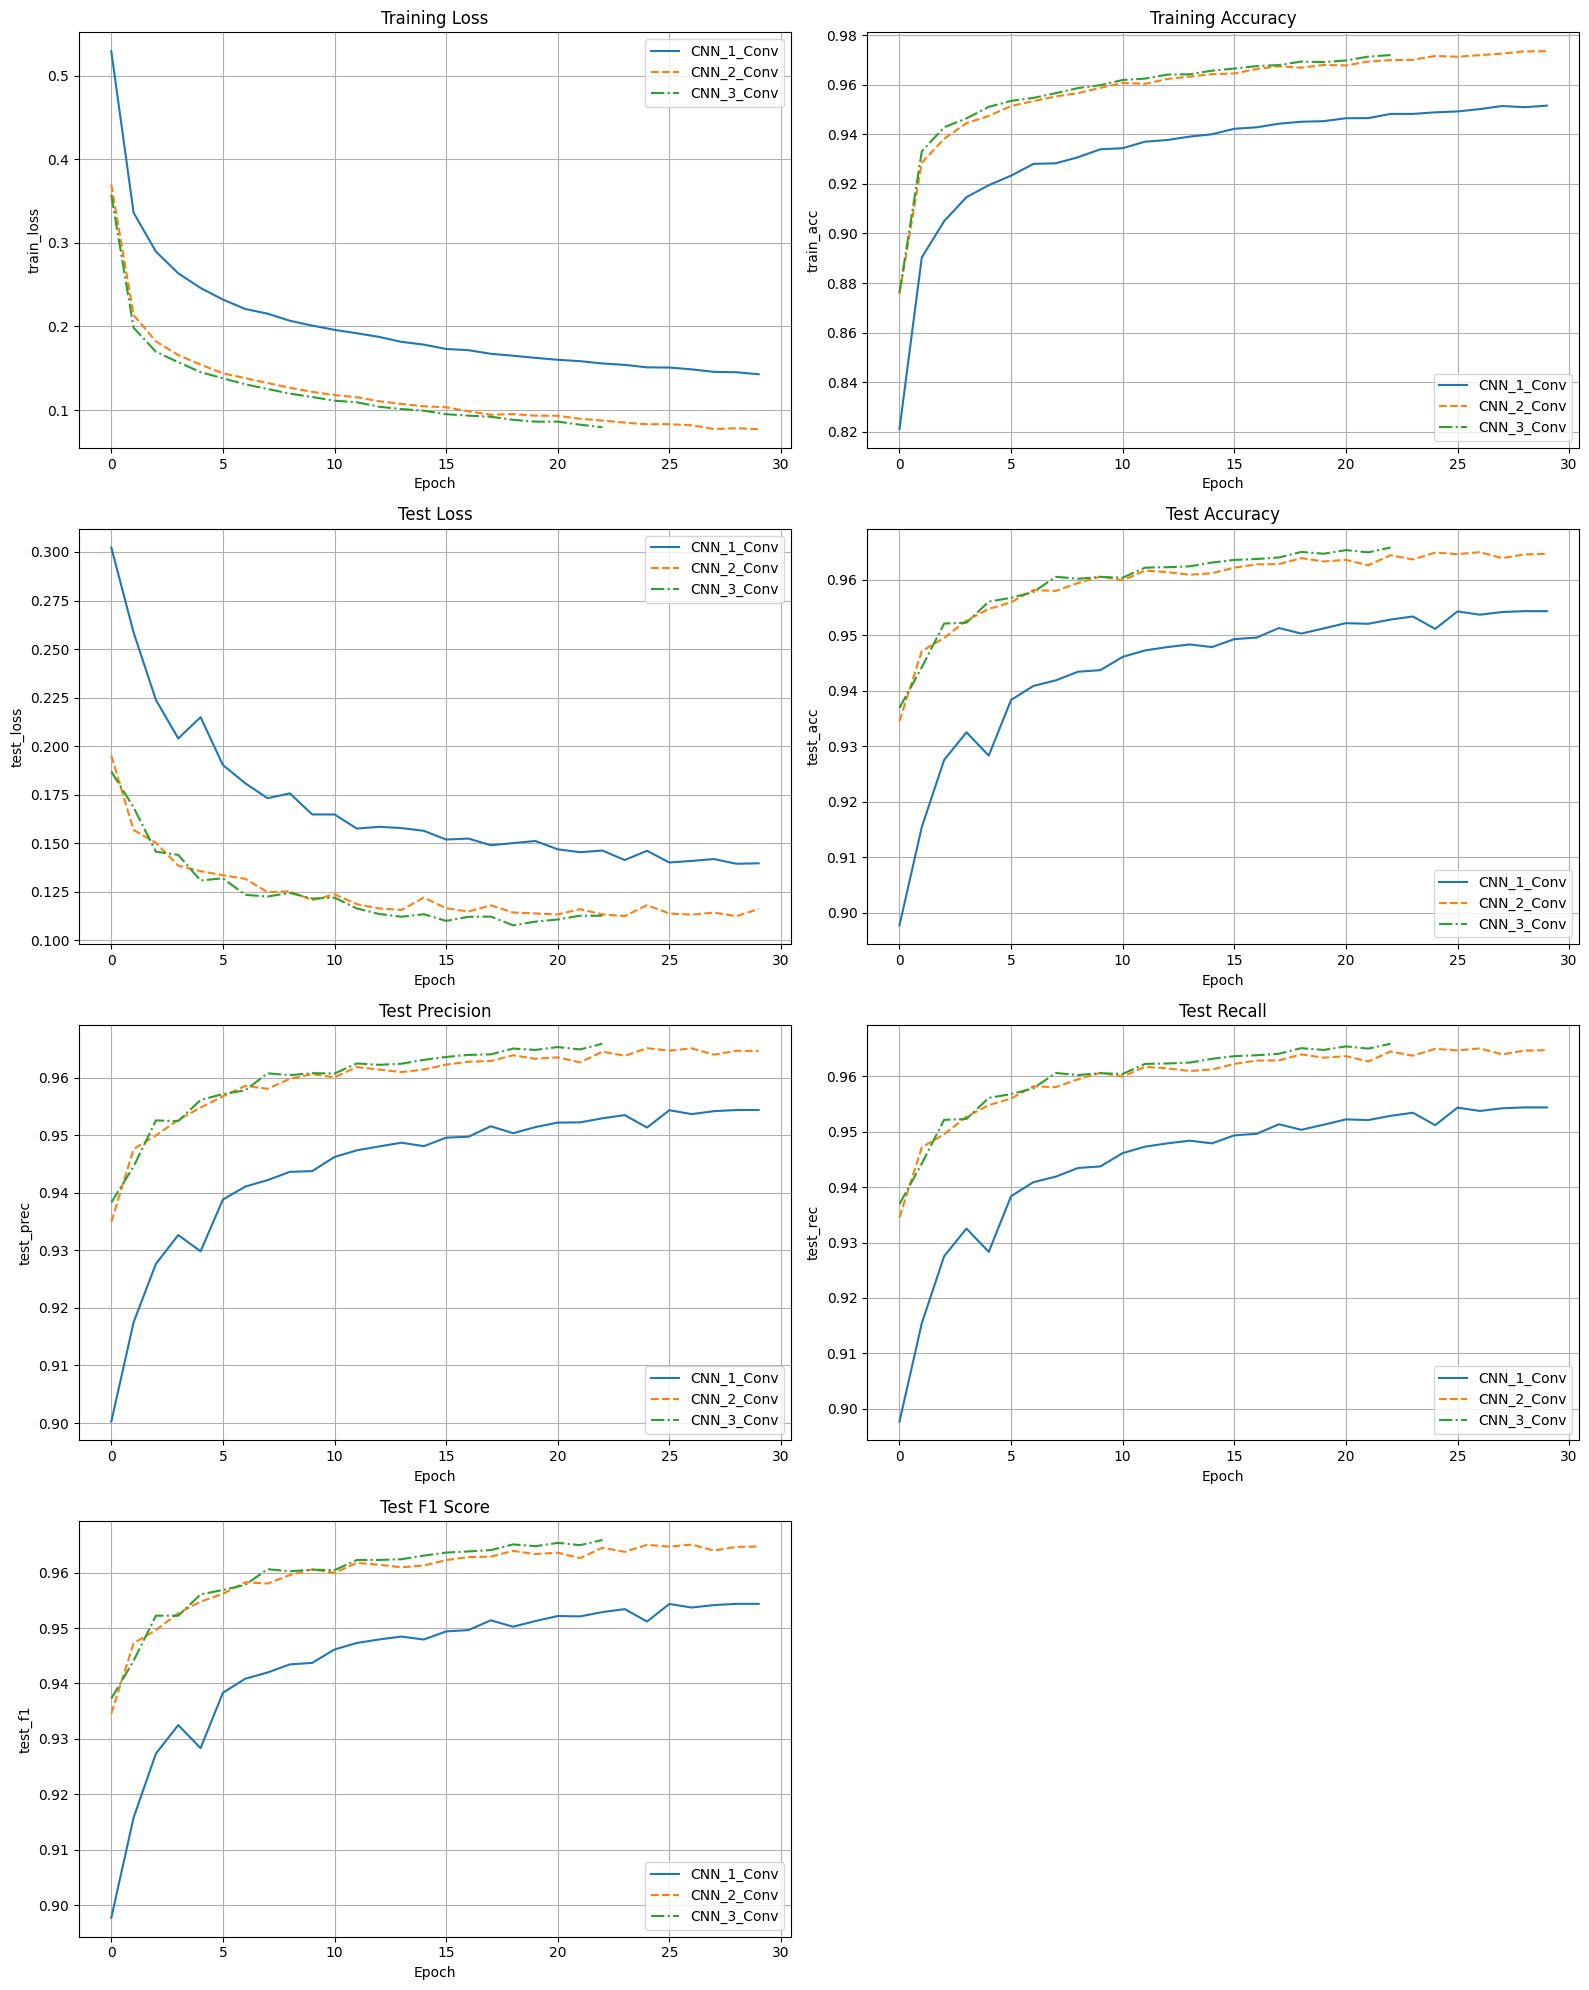

In [6]:
# Plot training
plot_training_history(cnn_conv_layer_models_results)

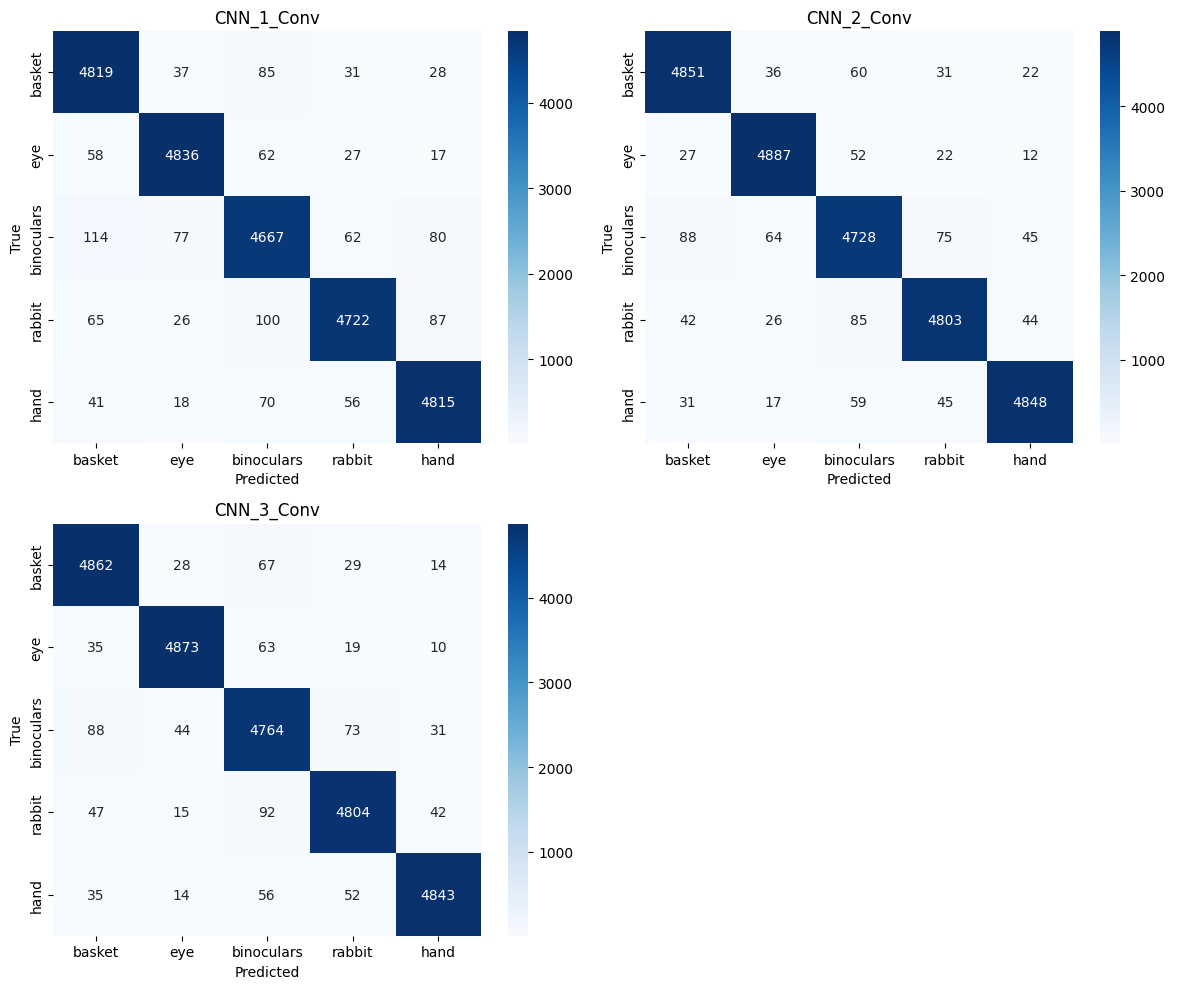

In [7]:
# Plot confusion matrices
plot_confusion_matrices(cnn_conv_layer_models_results)

#### Test 2: Amount of kernels

Now I want to determine how many kernels provide the best ratio between accuracy and model size.

- 8 + 16 Kernels
- 16 + 32 Kernels
- 24 + 48 Kernels
- 32 + 64 Kernels
- 40 + 80 Kernels
- 48 + 96 Kernels

##### Result:
2 Convolutional + Pooling Layers perform considerably better than 1. However three layers are only marginally better despite having more parameters in the convolutional parts of the network. 

The confusion matrices for all three models look very good. None of the given models seems to have problems with classifying a particular class.

So I will choose 2 Convolutional + Pooling Layers for my classifier.

In [8]:
nets = 6

cnn_num_kernels_models = {f'CNN_{n*8+8}_{n*16+16}_Kernels': BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_num_kernels_models.values()):
    model.layers.append(nn.Conv2d(1, i*8+8, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(i*8+8, i*16+16, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear((i*16+16)*7*7, 256))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_num_kernels_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
         LeakyReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
         LeakyReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
           Flatten-7                  [-1, 784]               0
            Linear-8                  [-1, 256]         200,960
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 205,669
Trainable params: 205,669
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.78
Estimated T

In [9]:
cnn_num_kernels_models_result = evaluate_models(cnn_num_kernels_models)

Start training CNN_8_16_Kernels
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.4475 | Train Acc: 0.8497 | Test Acc: 0.9194 | Test F1: 0.9195
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2676 | Train Acc: 0.9118 | Test Acc: 0.9311 | Test F1: 0.9308
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.2322 | Train Acc: 0.9228 | Test Acc: 0.9397 | Test F1: 0.9399
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.2116 | Train Acc: 0.9287 | Test Acc: 0.9421 | Test F1: 0.9422
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1967 | Train Acc: 0.9338 | Test Acc: 0.9463 | Test F1: 0.9463
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1861 | Train Acc: 0.9376 | Test Acc: 0.9484 | Test F1: 0.9483
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1775 | Train Acc: 0.9404 | Test Acc: 0.9507 | Test F1: 0.9508
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1717 | Train Acc: 0.9416 | Test Acc: 0.9506 | Test F1: 0.9505
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1641 | Train Acc: 0.9442 | Test Acc: 0.9480 | Test F1: 0.9482
Epoch

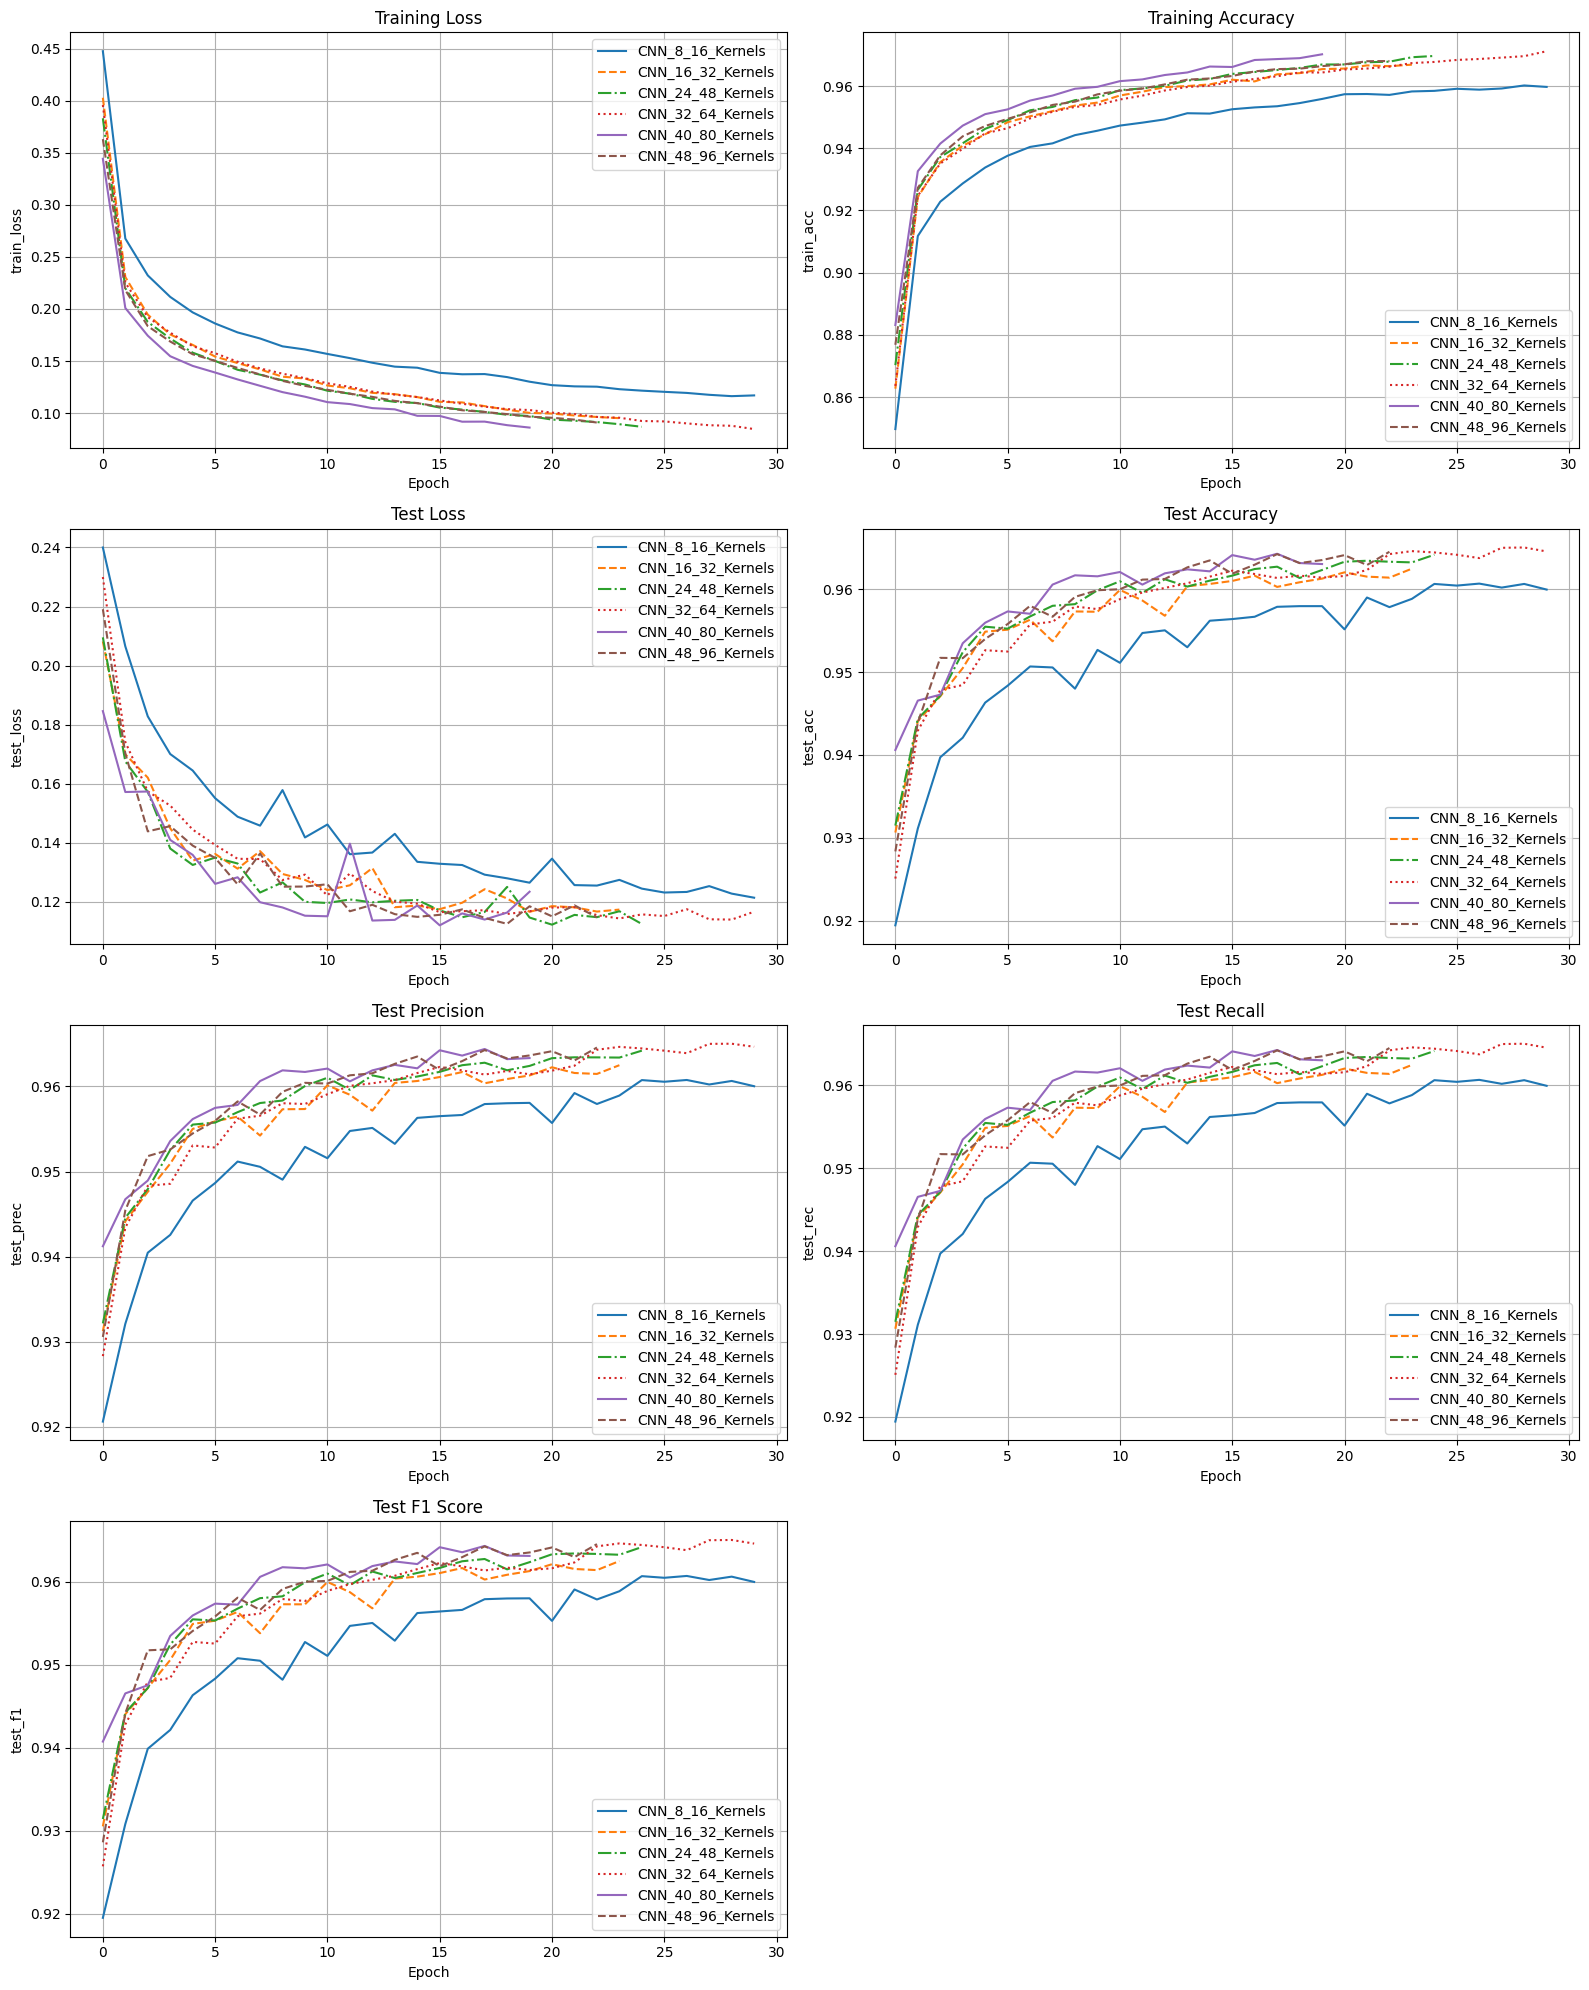

In [10]:
plot_training_history(cnn_num_kernels_models_result)

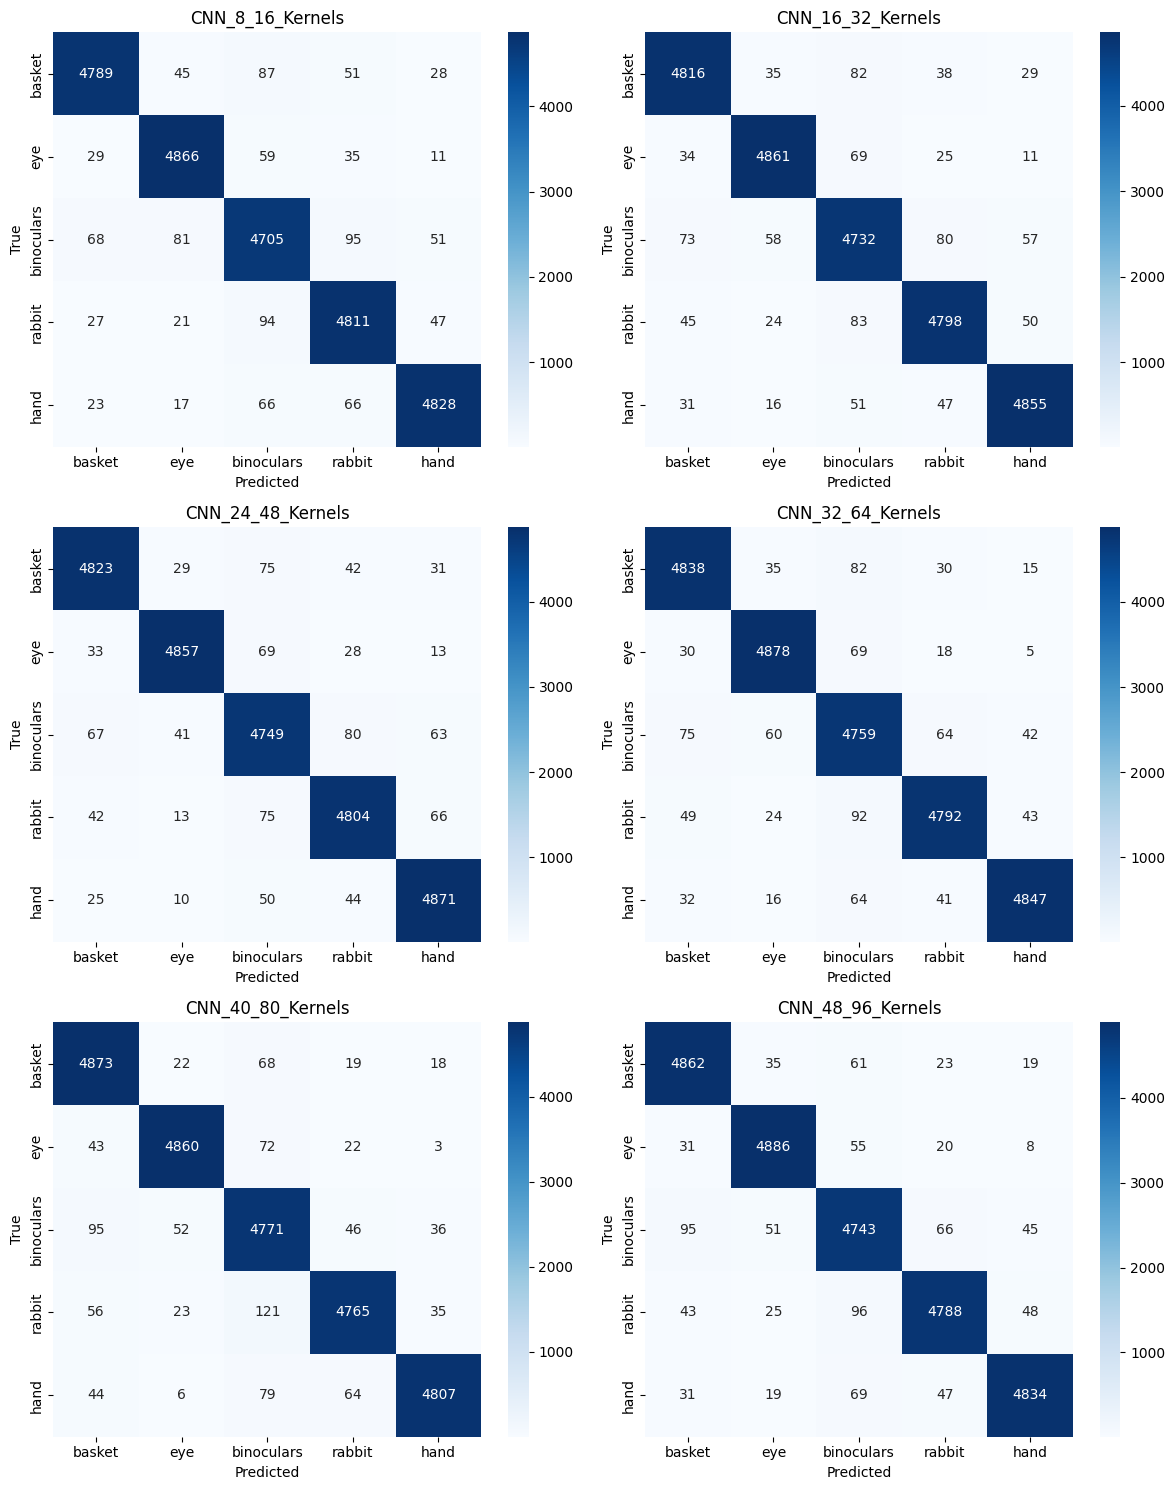

In [11]:
plot_confusion_matrices(cnn_num_kernels_models_result)

##### Result:

You can observe that increasing the number of kernel from 8+16 to 16+32 yields considerable performance improvements. The other combinations perform pretty similar, with 32+64 kernels having the highest accuracy

The confusion matrices continue to look good, without large confusion between two classes.

Therefore I will choose to continue with 32+64 kernels.

#### Test 3: Amount of dense layers

Next I need to inspect if adding multiple dense layers increases model performance.

- 1 Dense Layer
- 2 Dense Layers

In [43]:
nets = 2
cnn_num_dense_layer_models = {f'CNN_{n+1}_Dense': BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_num_dense_layer_models.values()):
    model.layers.append(nn.Conv2d(1, 32, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(32, 64, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(64*7*7, 256))
    model.layers.append(nn.LeakyReLU())

    if i == 1:
        model.layers.append(nn.Linear(256, 128))
        model.layers.append(nn.LeakyReLU())
        model.layers.append(nn.Linear(128, 5))
    else:
        model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_num_dense_layer_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         LeakyReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
         LeakyReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 256]         803,072
         LeakyReLU-9                  [-1, 256]               0
           Linear-10                    [-1, 5]           1,285
Total params: 856,453
Trainable params: 856,453
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 3.27
Estimated T

In [44]:
cnn_num_dense_layer_models_result = evaluate_models(cnn_num_dense_layer_models)

Start training CNN_1_Dense
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.3925 | Train Acc: 0.8654 | Test Acc: 0.9321 | Test F1: 0.9322
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2254 | Train Acc: 0.9249 | Test Acc: 0.9448 | Test F1: 0.9448
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.1936 | Train Acc: 0.9354 | Test Acc: 0.9472 | Test F1: 0.9472
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.1753 | Train Acc: 0.9403 | Test Acc: 0.9519 | Test F1: 0.9520
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1647 | Train Acc: 0.9441 | Test Acc: 0.9540 | Test F1: 0.9541
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1571 | Train Acc: 0.9458 | Test Acc: 0.9539 | Test F1: 0.9540
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1478 | Train Acc: 0.9501 | Test Acc: 0.9561 | Test F1: 0.9561
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1417 | Train Acc: 0.9510 | Test Acc: 0.9563 | Test F1: 0.9562
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1364 | Train Acc: 0.9536 | Test Acc: 0.9569 | Test F1: 0.9569
Epoch 10 |

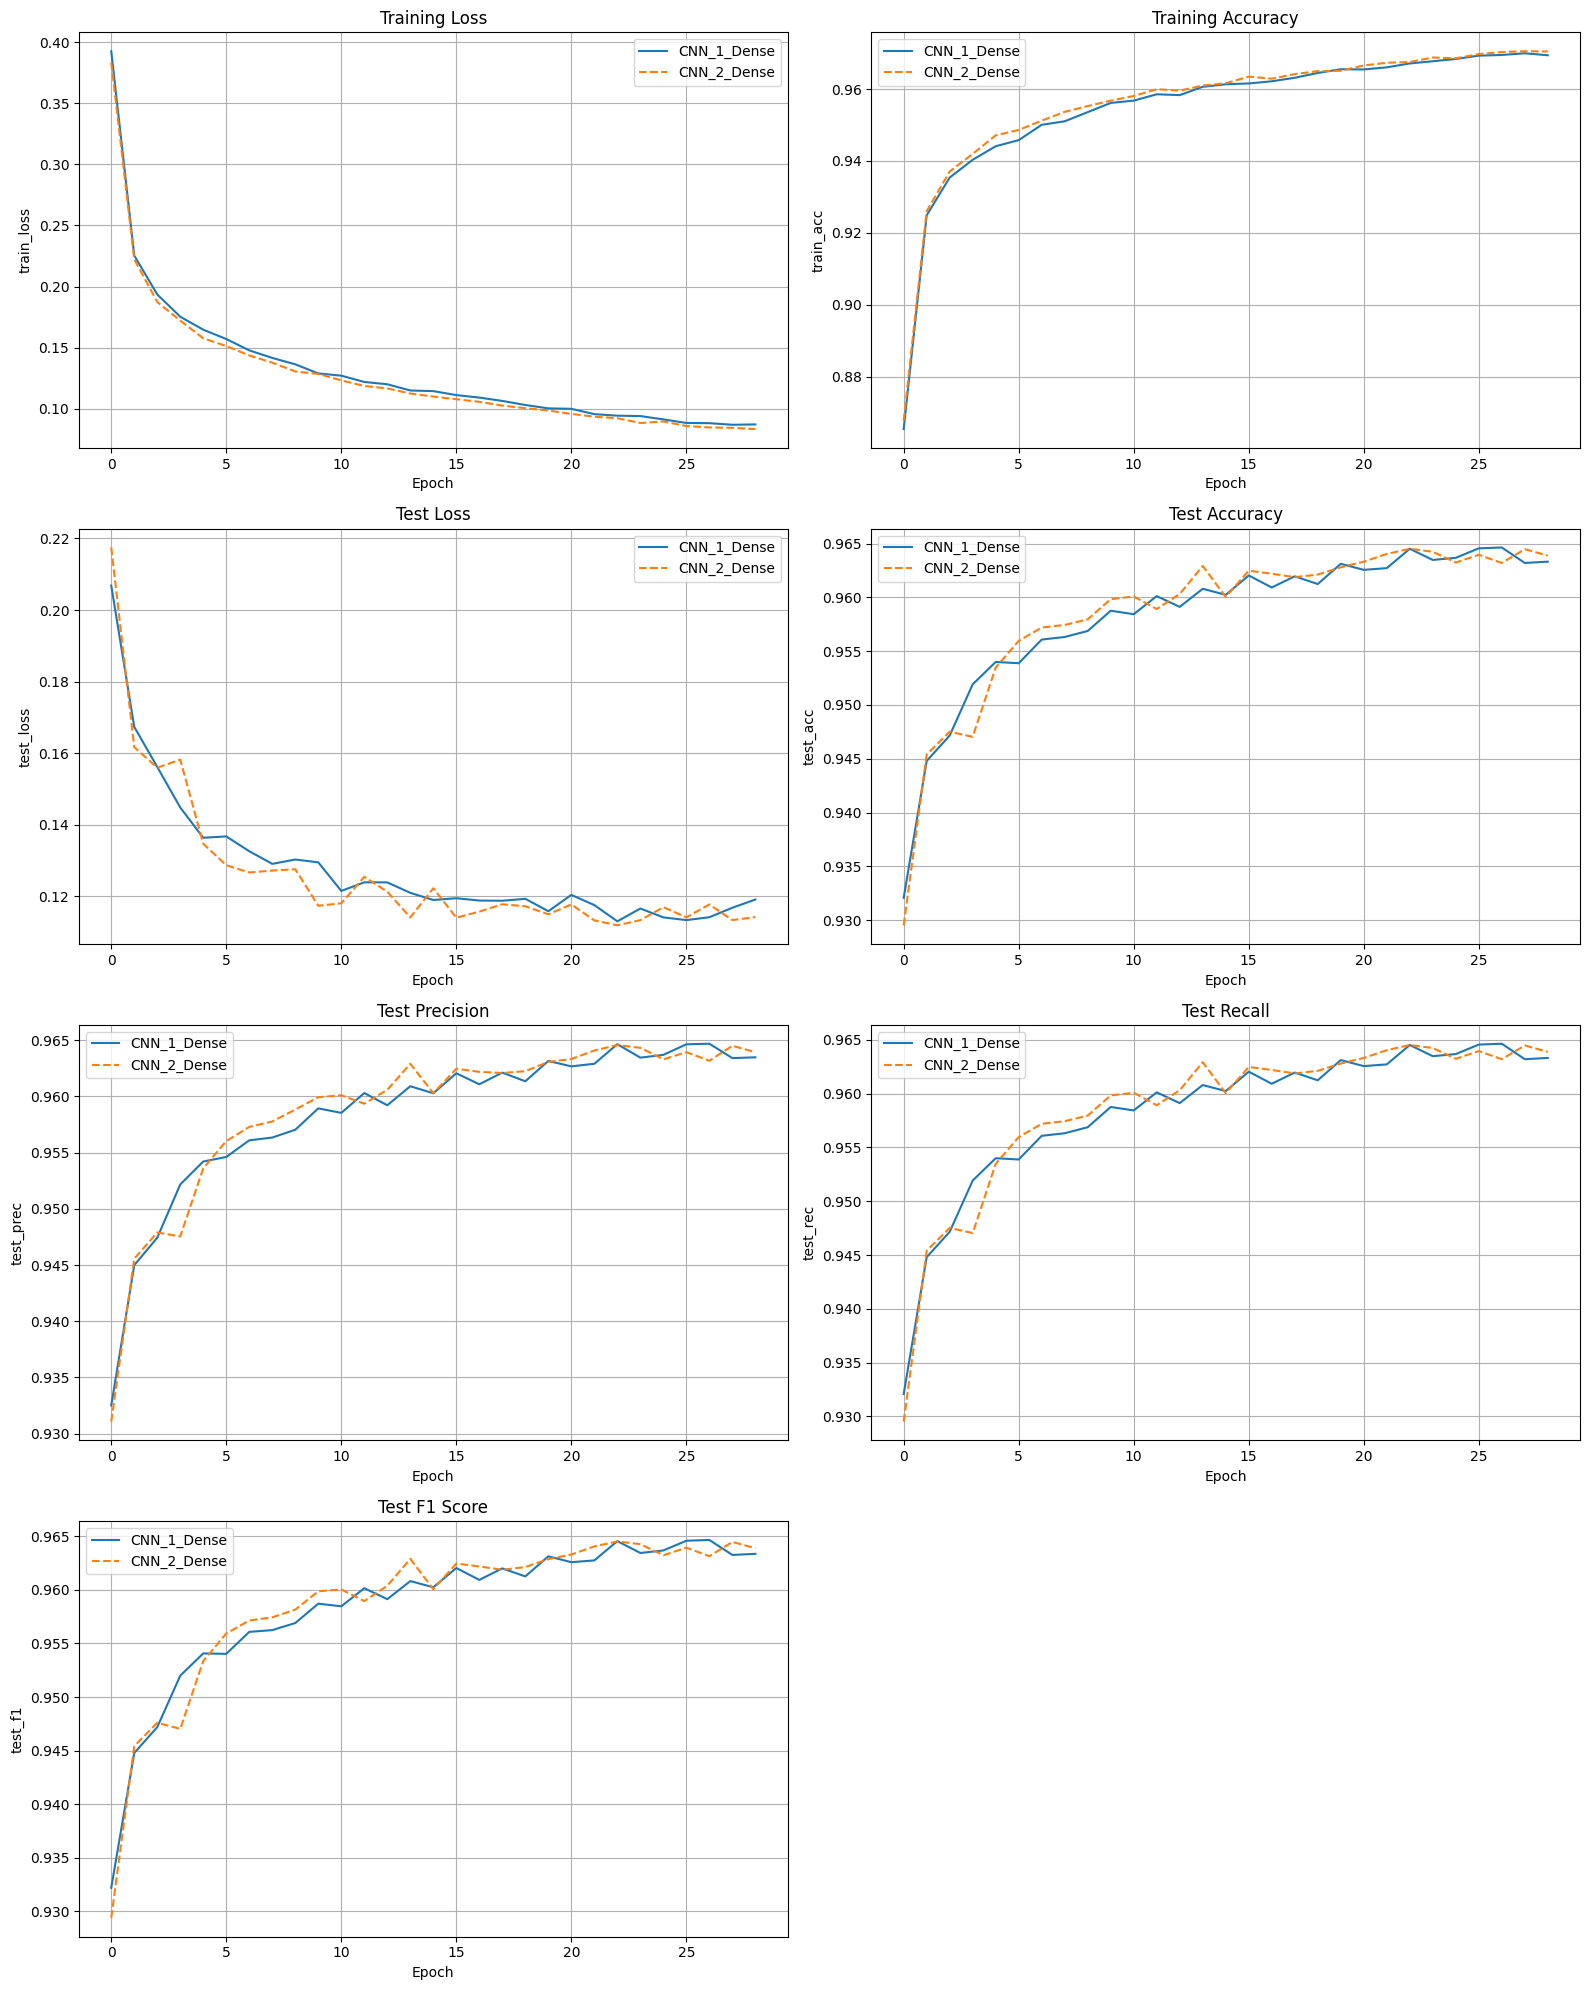

In [45]:
plot_training_history(cnn_num_dense_layer_models_result)

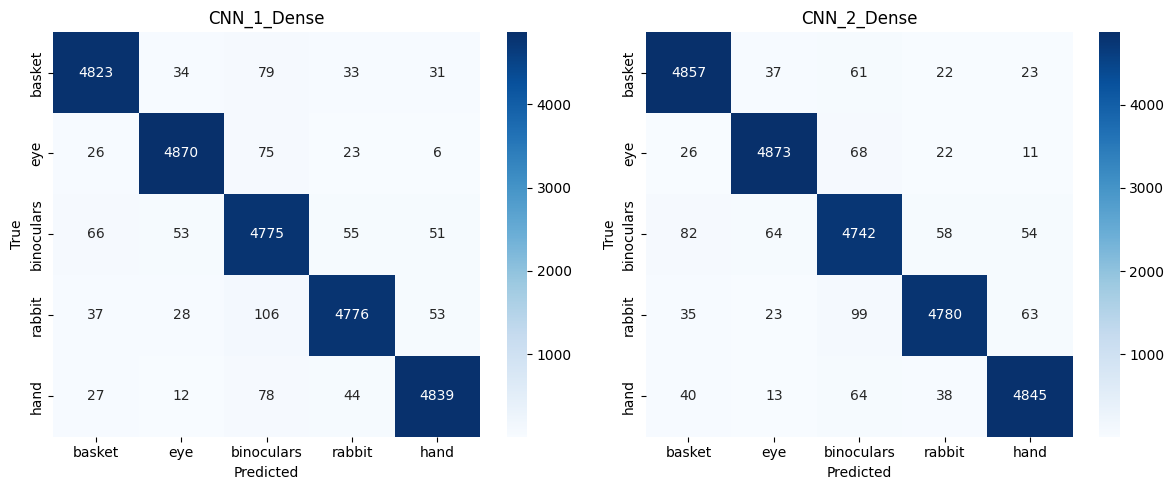

In [46]:
plot_confusion_matrices(cnn_num_dense_layer_models_result)

##### Result:

One can clearly infer that there is no use in adding an additional dense layer to the model.

#### Test 4: How many neurons in my dense layer ?

With this test I want to explore the optimal number of neurons in my dense layer.

- 32 Neurons
- 64 Neurons
- 128 Neurons
- 256 Neurons
- 512 Neurons
- 1024 Neurons

In [55]:
nets = 6
cnn_dense_layer_neuron_models = {f"CNN_{2**(n+5)}_Neurons": BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_dense_layer_neuron_models.values()):
    model.layers.append(nn.Conv2d(1, 32, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(32, 64, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(64*7*7, 2**(i+5)))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Linear(2**(i+5), 5))

    model.to(DEVICE)

print_model_summary(cnn_dense_layer_neuron_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         LeakyReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
         LeakyReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                   [-1, 32]         100,384
         LeakyReLU-9                   [-1, 32]               0
           Linear-10                    [-1, 5]             165
Total params: 152,645
Trainable params: 152,645
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 0.58
Estimated T

In [56]:
cnn_dense_layer_neuron_models_result = evaluate_models(cnn_dense_layer_neuron_models)

Start training CNN_32_Neurons
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.3965 | Train Acc: 0.8667 | Test Acc: 0.9304 | Test F1: 0.9305
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2298 | Train Acc: 0.9239 | Test Acc: 0.9429 | Test F1: 0.9429
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.1963 | Train Acc: 0.9342 | Test Acc: 0.9486 | Test F1: 0.9486
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.1790 | Train Acc: 0.9393 | Test Acc: 0.9489 | Test F1: 0.9490
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1660 | Train Acc: 0.9441 | Test Acc: 0.9542 | Test F1: 0.9542
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1555 | Train Acc: 0.9475 | Test Acc: 0.9542 | Test F1: 0.9543
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1496 | Train Acc: 0.9489 | Test Acc: 0.9572 | Test F1: 0.9572
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1440 | Train Acc: 0.9508 | Test Acc: 0.9562 | Test F1: 0.9561
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1391 | Train Acc: 0.9523 | Test Acc: 0.9570 | Test F1: 0.9570
Epoch 1

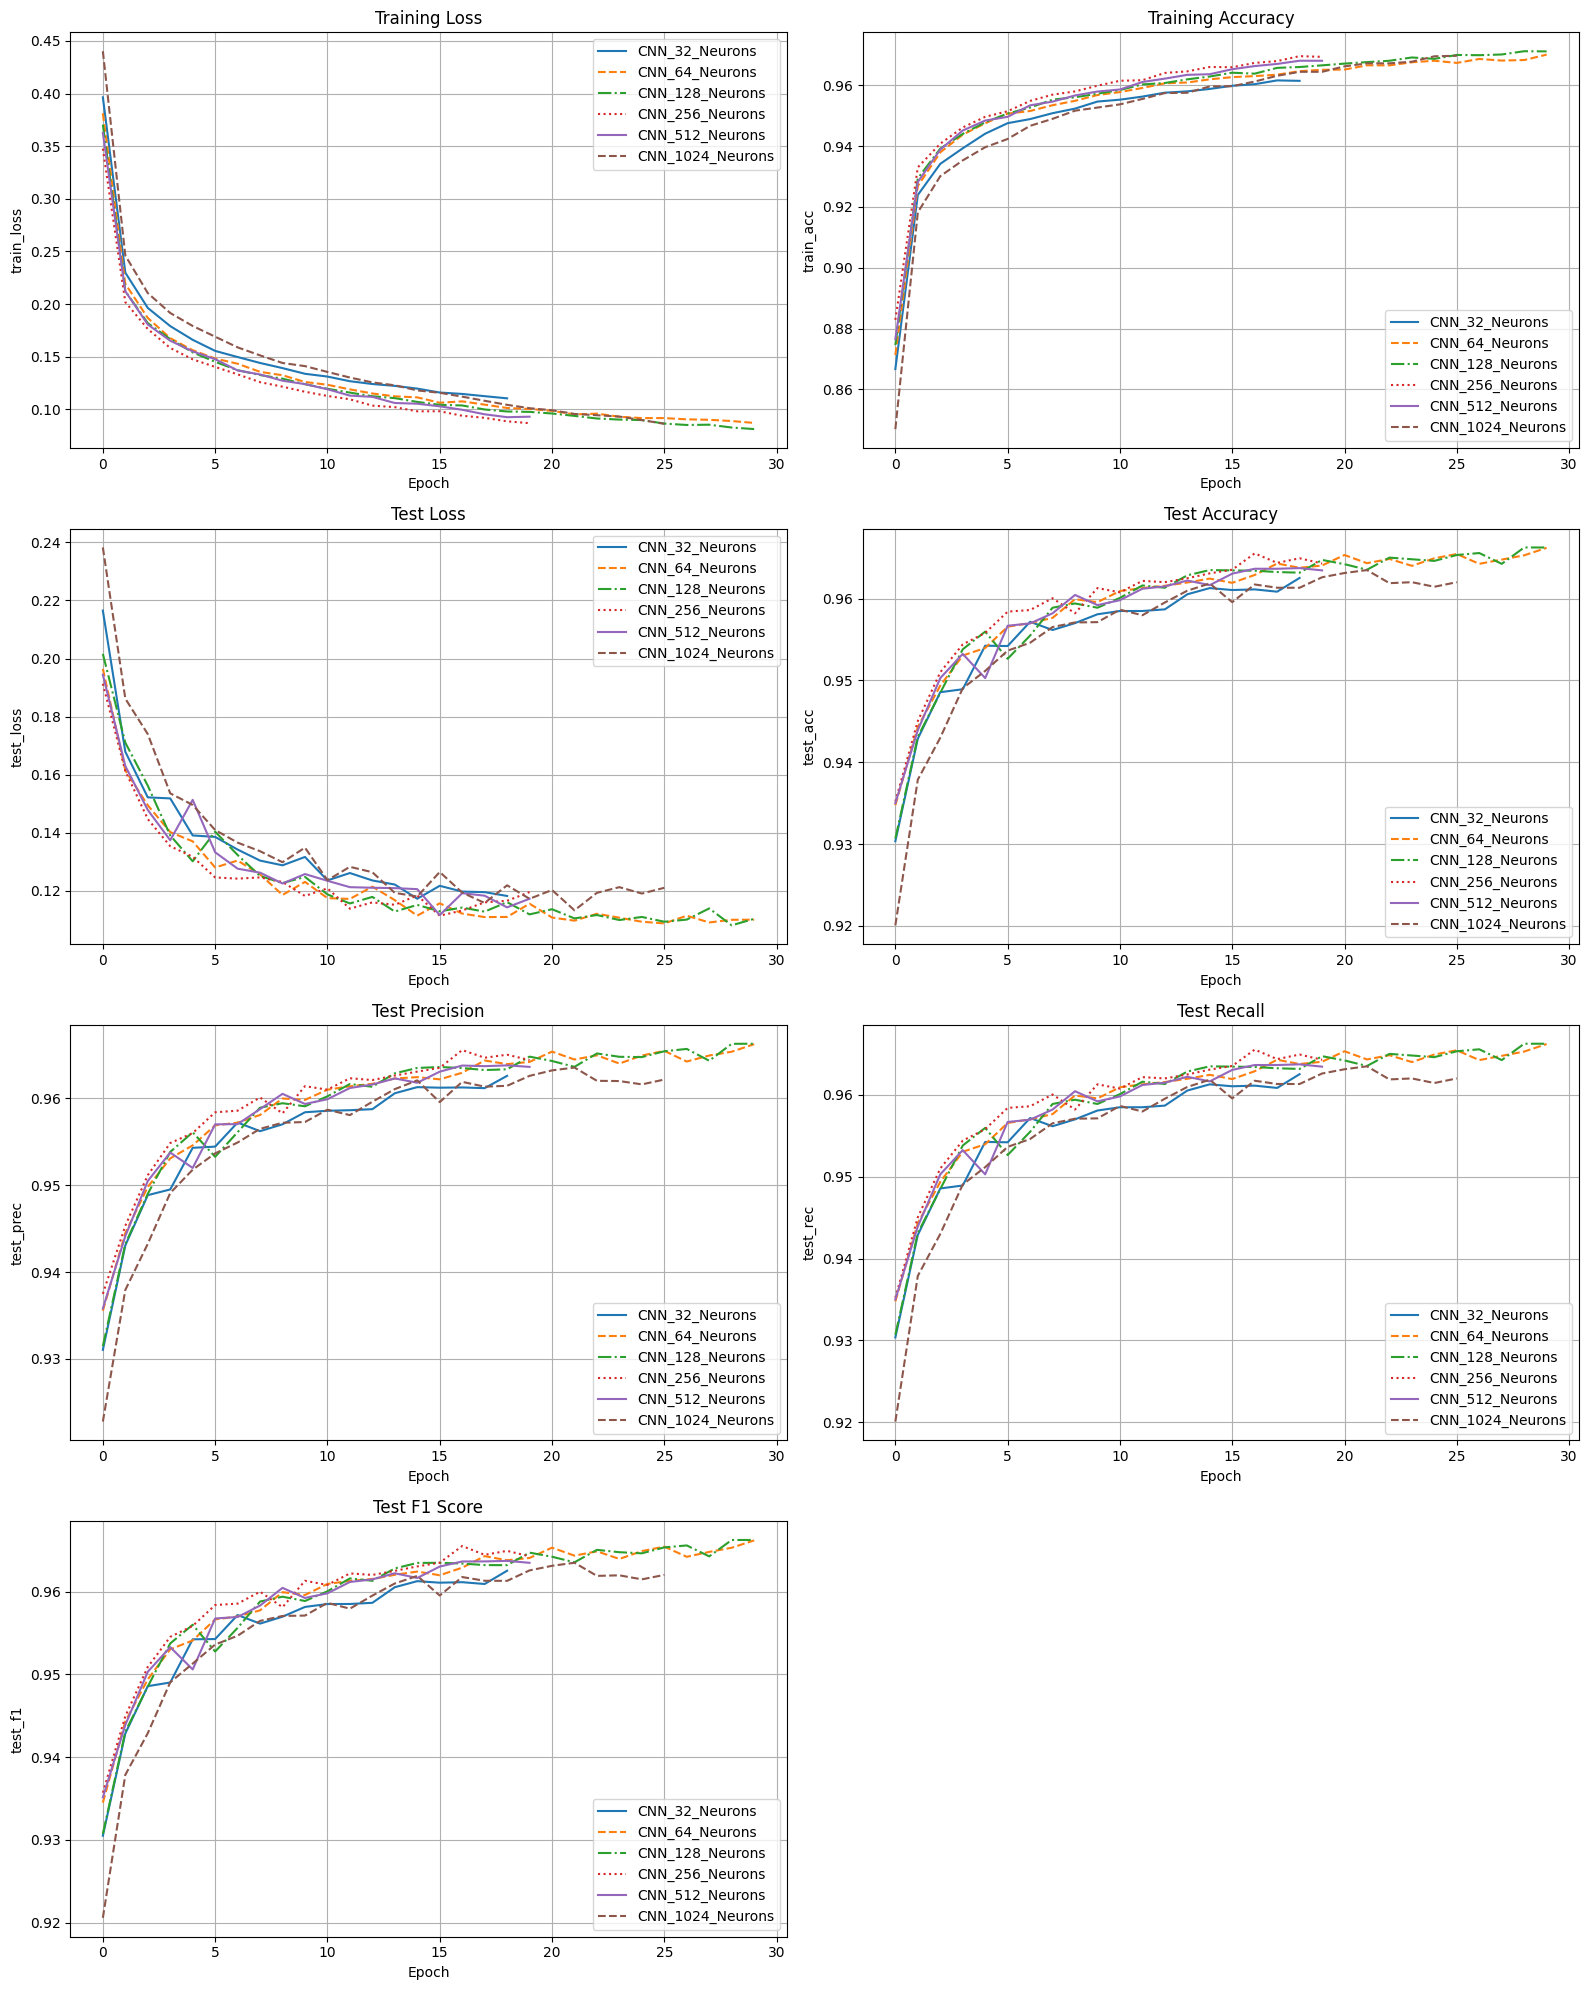

In [57]:
plot_training_history(cnn_dense_layer_neuron_models_result)

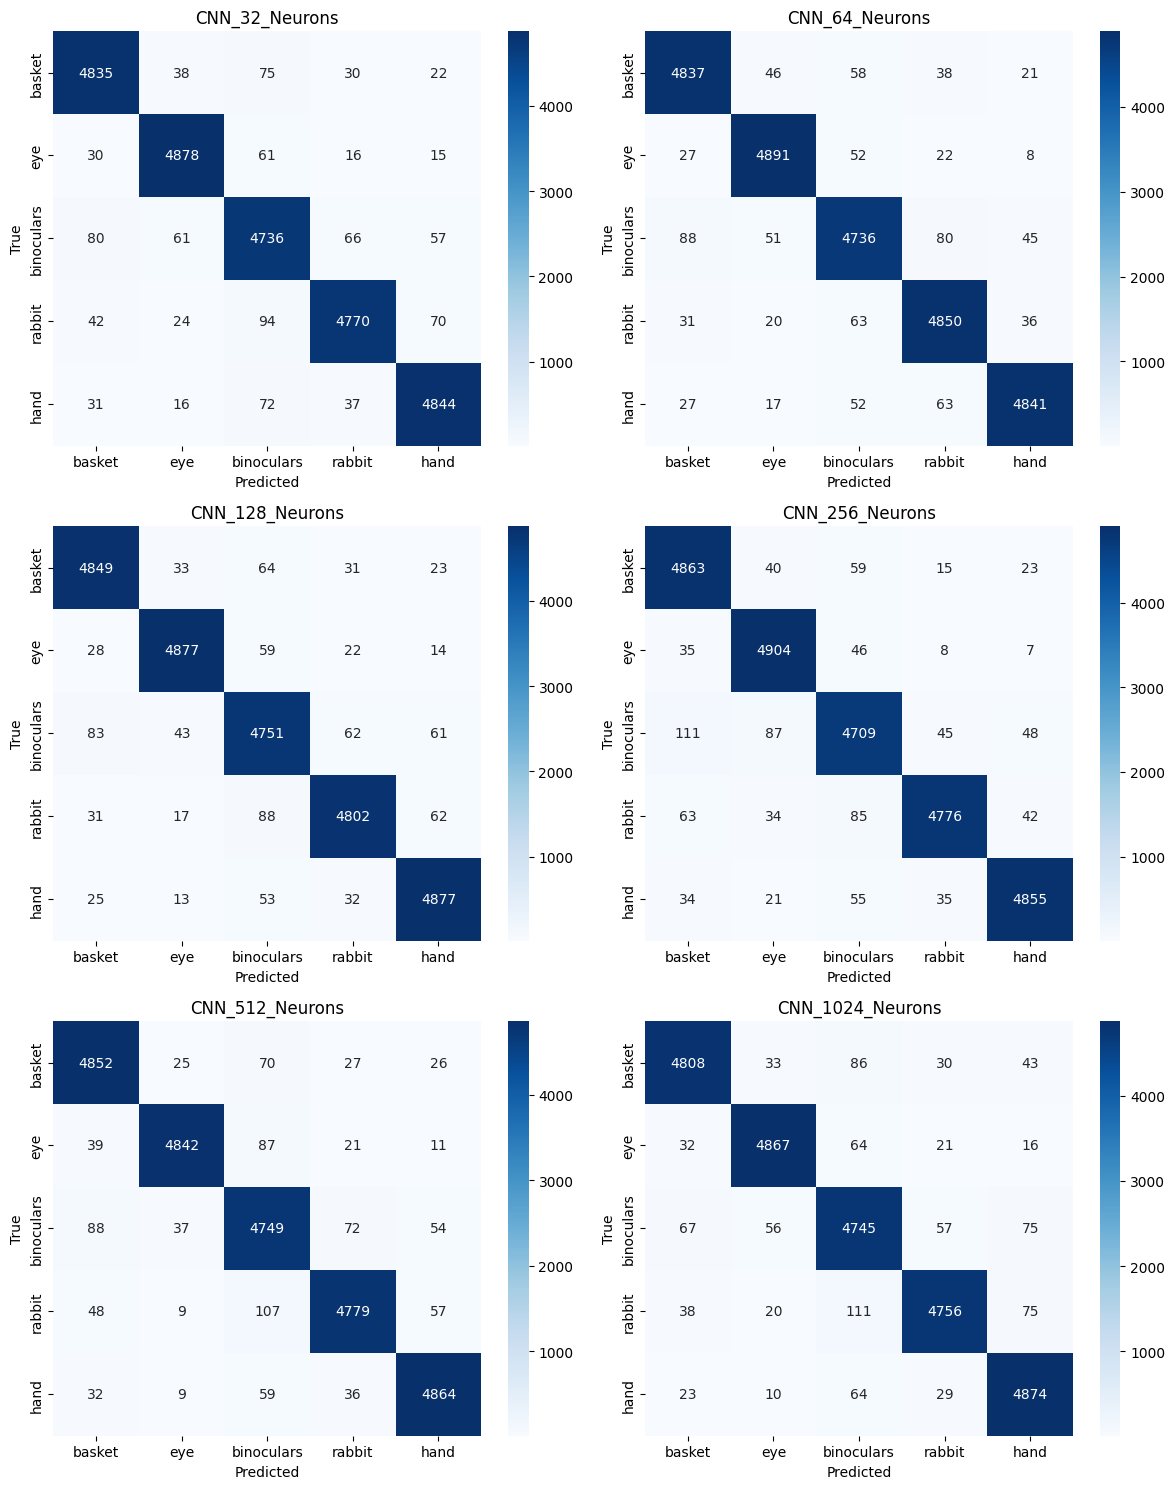

In [58]:
plot_confusion_matrices(cnn_dense_layer_neuron_models_result)

##### Result:

256 Neurons inside of the dense layers yield the best performance in the model.

Still no problems with major confusion.

Therefore I will go with 256 neurons

#### Test 5: How much dropout ?

Dropout should be introduced to further optimize model performance

- 0 % - no dropout
- 10 %
- 20 %
- 30 %
- 40 %
- 50 %
- 60 %
- 70 %

In [59]:
nets = 8
cnn_dropout_models = {f"CNN_{n*0.1:.1f}_Dropout": BaseModule() for n in range(nets)}

for i, model in enumerate(cnn_dropout_models.values()):
    model.layers.append(nn.Conv2d(1, 32, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Dropout(i*0.1))
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(32, 64, kernel_size=5, padding='same'))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Dropout(i*0.1))
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(64*7*7, 256))
    model.layers.append(nn.LeakyReLU())
    model.layers.append(nn.Dropout(i*0.1))
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_dropout_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         LeakyReLU-2           [-1, 32, 28, 28]               0
           Dropout-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          51,264
         LeakyReLU-6           [-1, 64, 14, 14]               0
           Dropout-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 256]         803,072
        LeakyReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 5]           1,285
Total params: 856,453
Trainable params:

In [60]:
cnn_dropout_models_result = evaluate_models(cnn_dropout_models)

Start training CNN_0.0_Dropout
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.3408 | Train Acc: 0.8852 | Test Acc: 0.9369 | Test F1: 0.9370
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2024 | Train Acc: 0.9324 | Test Acc: 0.9495 | Test F1: 0.9495
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.1732 | Train Acc: 0.9414 | Test Acc: 0.9520 | Test F1: 0.9519
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.1581 | Train Acc: 0.9462 | Test Acc: 0.9540 | Test F1: 0.9540
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1469 | Train Acc: 0.9500 | Test Acc: 0.9509 | Test F1: 0.9510
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1387 | Train Acc: 0.9526 | Test Acc: 0.9576 | Test F1: 0.9577
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1318 | Train Acc: 0.9544 | Test Acc: 0.9593 | Test F1: 0.9593
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1257 | Train Acc: 0.9570 | Test Acc: 0.9588 | Test F1: 0.9588
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1207 | Train Acc: 0.9588 | Test Acc: 0.9606 | Test F1: 0.9606
Epoch 

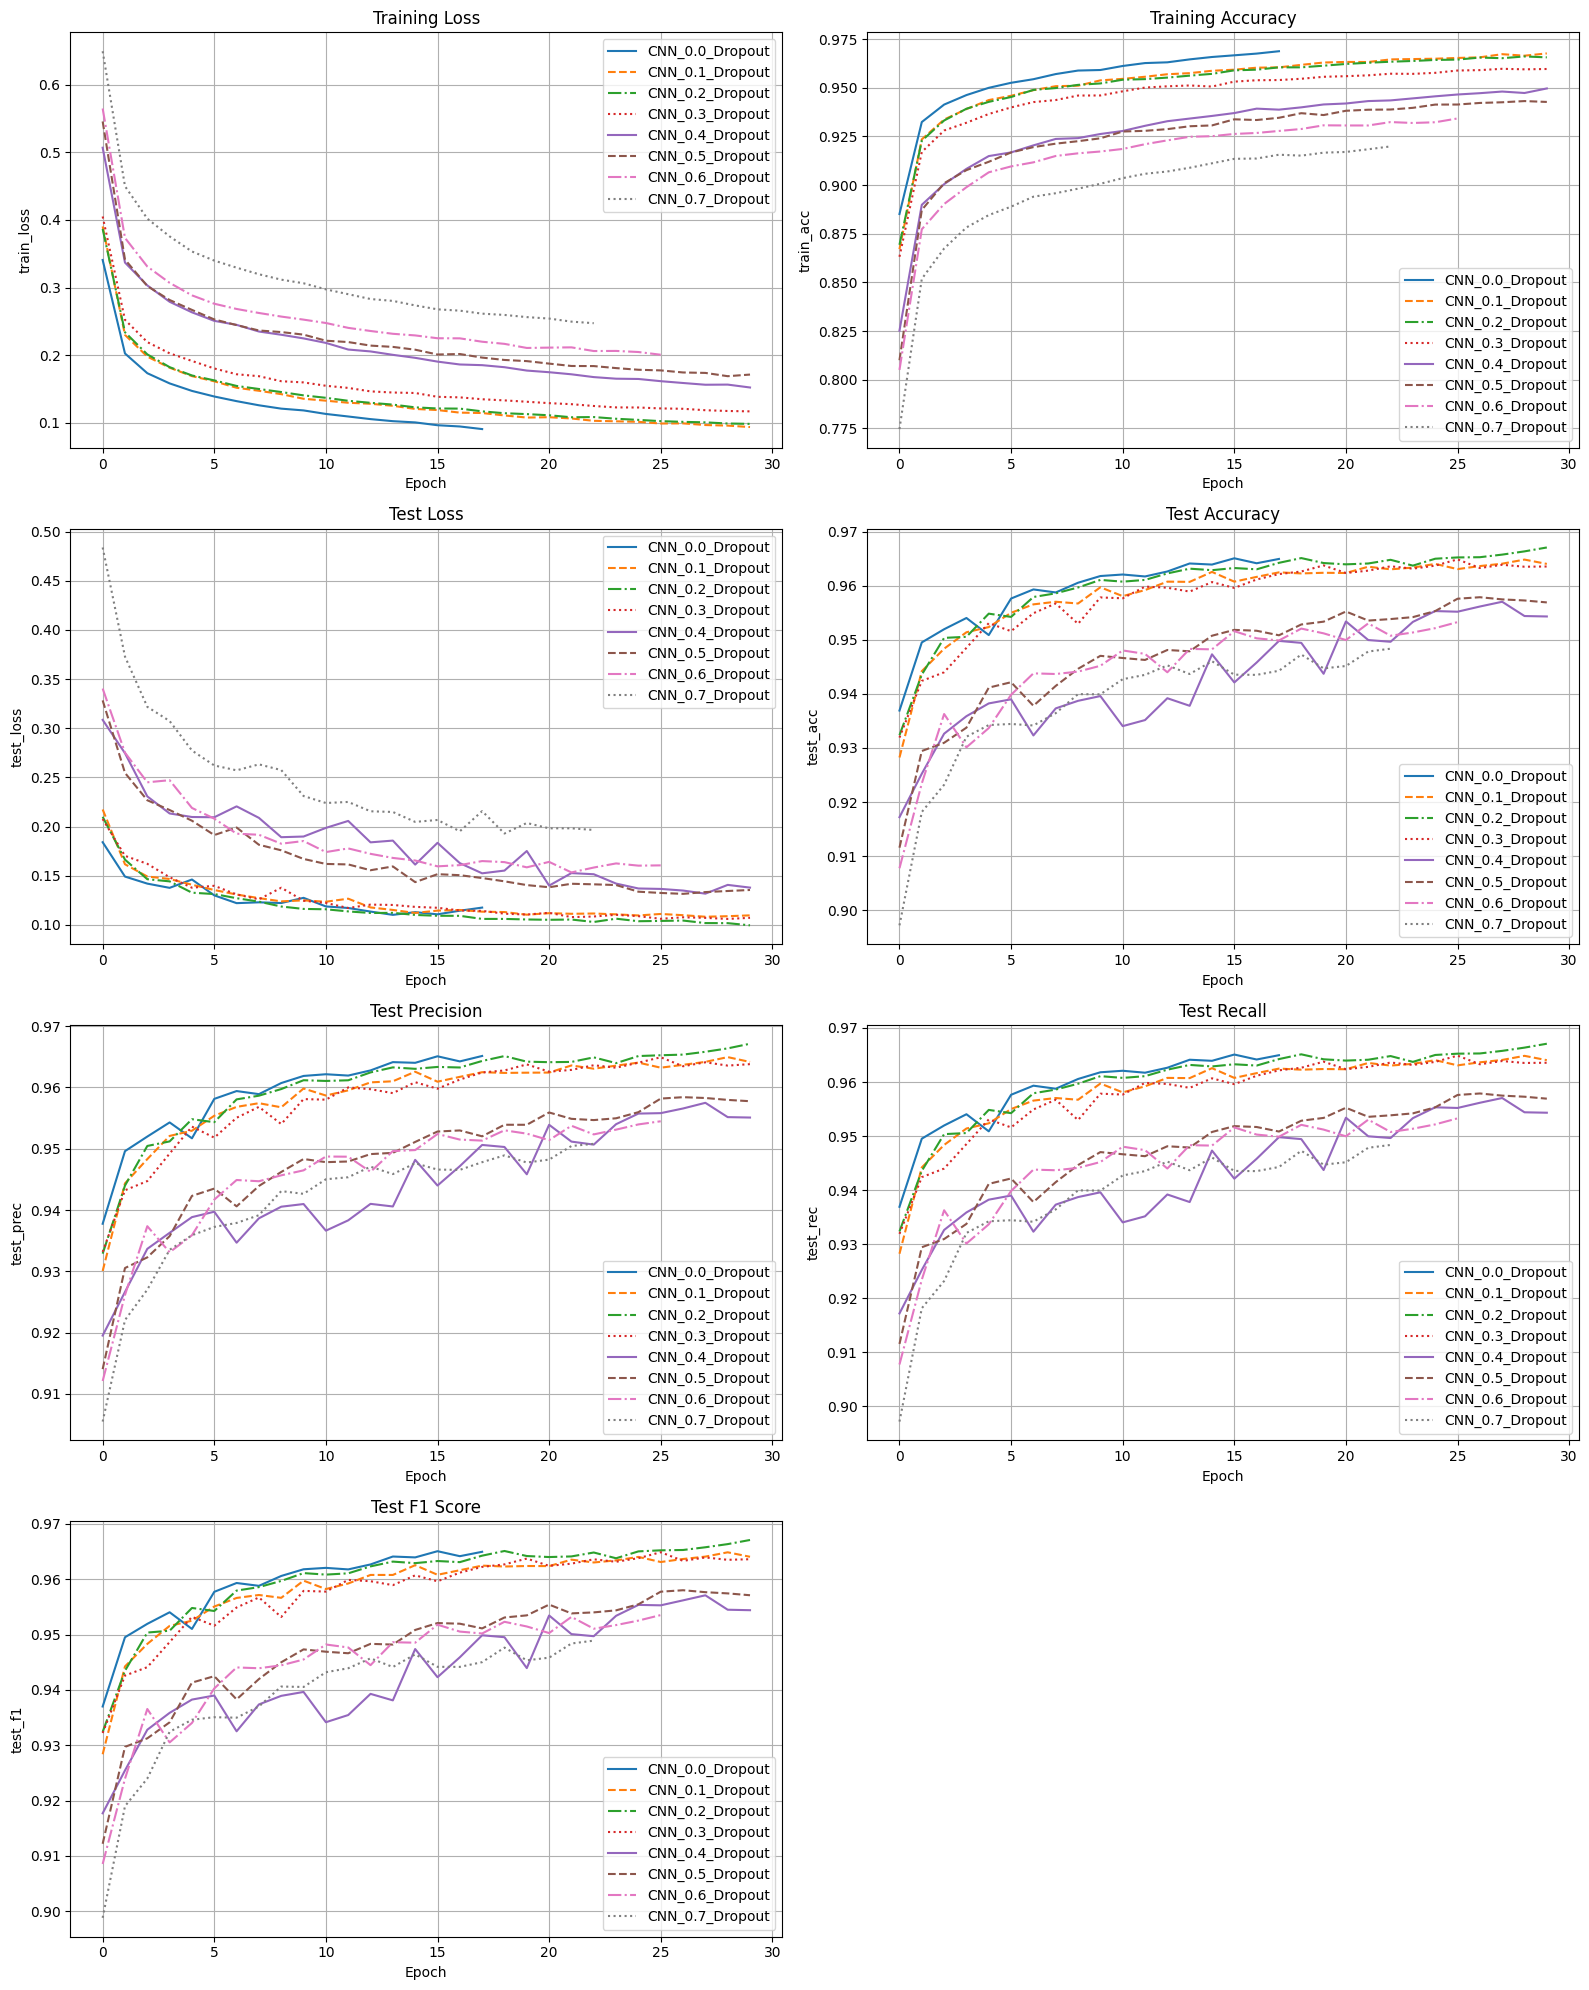

In [61]:
plot_training_history(cnn_dropout_models_result)

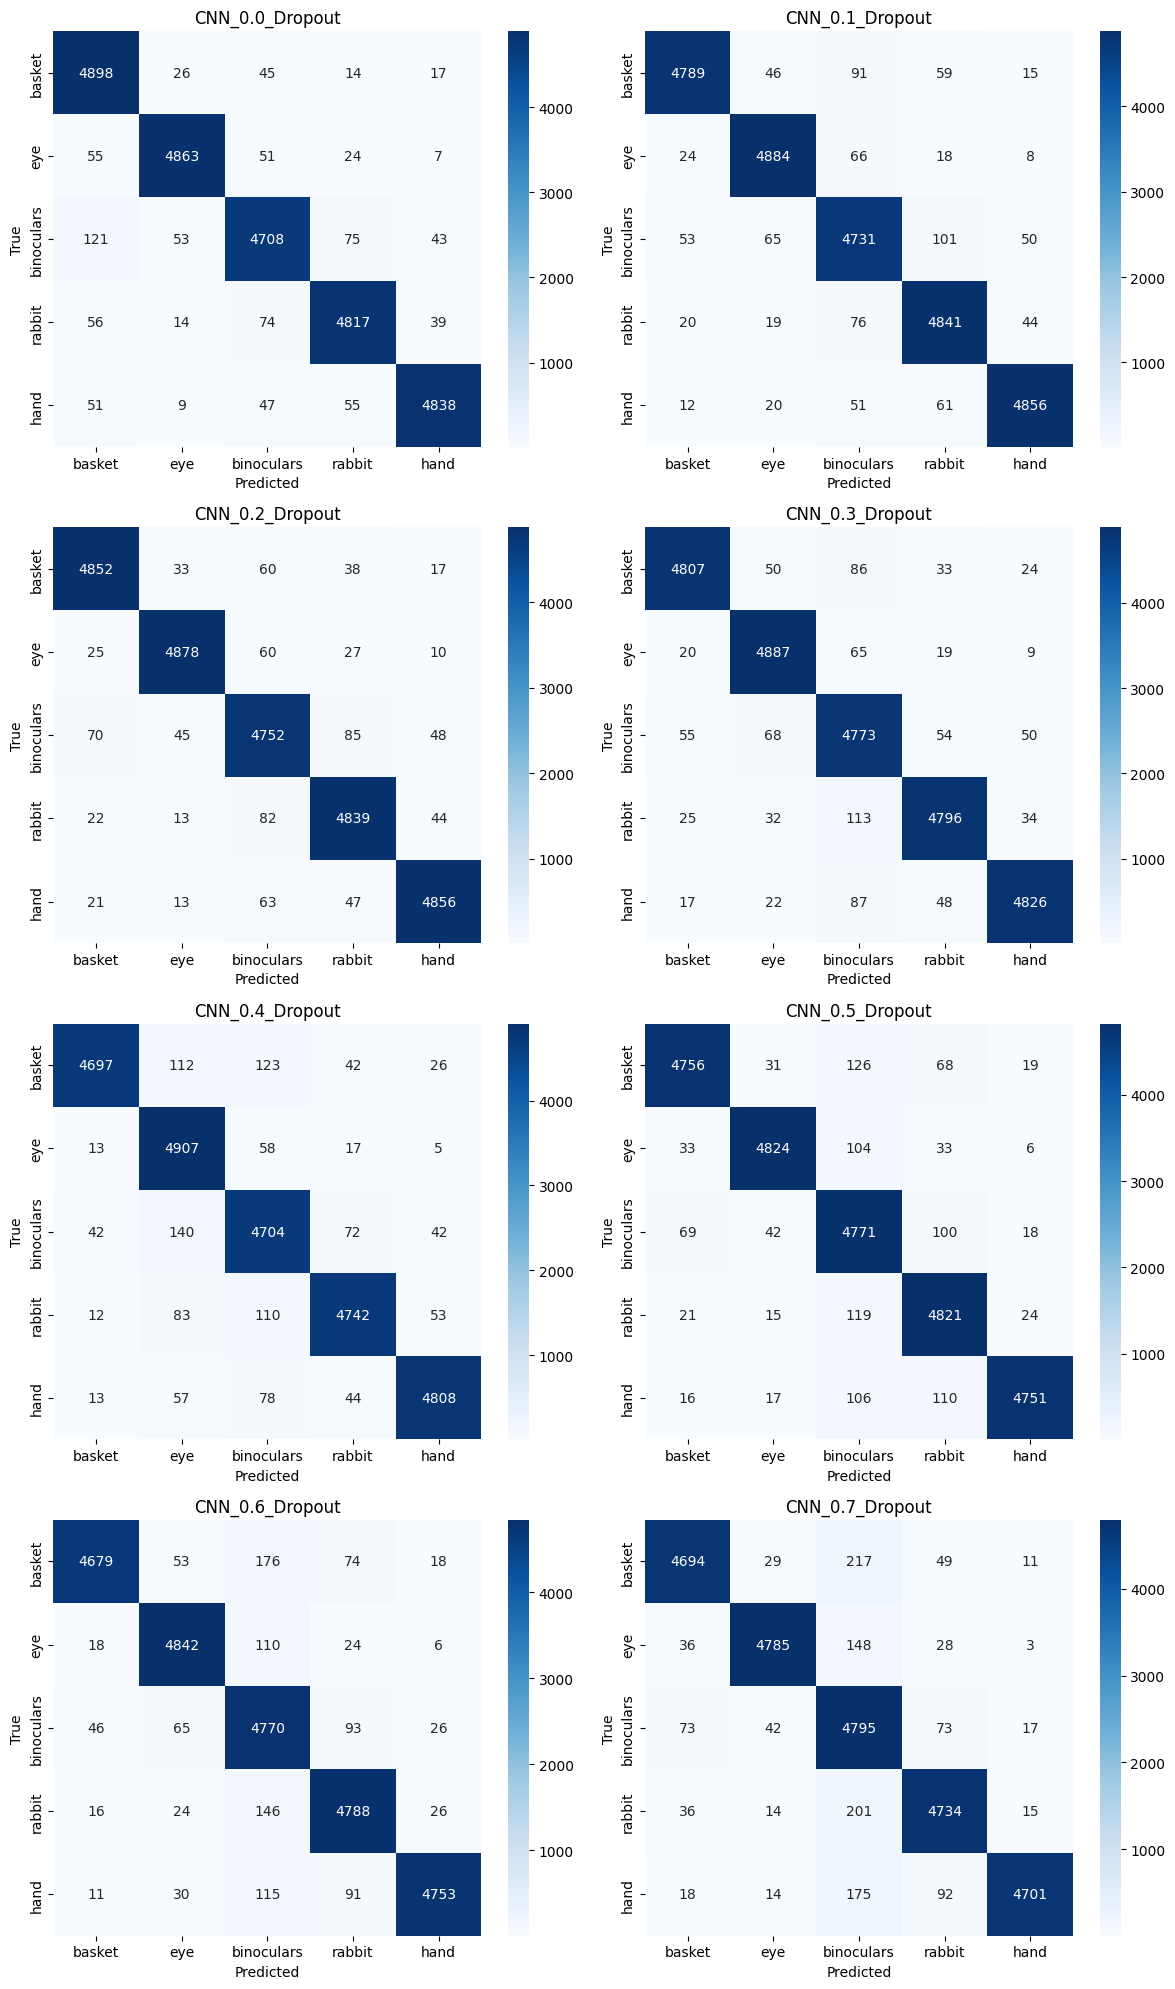

In [62]:
plot_confusion_matrices(cnn_dropout_models_result)

#### Result

Looking at the metrics you can quite clearly determine that the optimal dropout range is from 0.2 - 0.4. So I will equip the model with 0.3 dropout since this performs the best out of the three. 

### Test 6: Which activation function ?

During the earlier experiments I used the LeakyReLu activation function opposed to ReLu since I thought cutting of negative values might lose important information. Next I want to test this hypothesis by applying different activation functions to my model:

- ReLu
- LeakyReLu
- Sigmoid
- tanh

In [63]:

cnn_activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.Sigmoid(), nn.Tanh()]
cnn_activation_function_models = {f"CNN_{str(func.__class__.__name__)}_Activation": BaseModule() for func in cnn_activation_functions}

for i, model in enumerate(cnn_activation_function_models.values()):
    model.layers.append(nn.Conv2d(1, 32, kernel_size=5, padding='same'))
    model.layers.append(cnn_activation_functions[i])
    model.layers.append(nn.Dropout(0.3))
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Conv2d(32, 64, kernel_size=5, padding='same'))
    model.layers.append(cnn_activation_functions[i])
    model.layers.append(nn.Dropout(0.3))
    model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(64*7*7, 256))
    model.layers.append(cnn_activation_functions[i])
    model.layers.append(nn.Dropout(0.3))
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_activation_function_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
           Dropout-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          51,264
              ReLU-6           [-1, 64, 14, 14]               0
           Dropout-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 256]         803,072
             ReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 5]           1,285
Total params: 856,453
Trainable params:

In [64]:
cnn_activation_functions_result = evaluate_models(cnn_activation_function_models)

Start training CNN_ReLU_Activation
Epoch 1 | Learning Rate 0.0010
Train Loss: 0.4083 | Train Acc: 0.8618 | Test Acc: 0.9197 | Test F1: 0.9210
Epoch 2 | Learning Rate 0.0009
Train Loss: 0.2558 | Train Acc: 0.9153 | Test Acc: 0.9438 | Test F1: 0.9438
Epoch 3 | Learning Rate 0.0009
Train Loss: 0.2193 | Train Acc: 0.9274 | Test Acc: 0.9483 | Test F1: 0.9485
Epoch 4 | Learning Rate 0.0009
Train Loss: 0.2015 | Train Acc: 0.9334 | Test Acc: 0.9516 | Test F1: 0.9516
Epoch 5 | Learning Rate 0.0008
Train Loss: 0.1918 | Train Acc: 0.9355 | Test Acc: 0.9526 | Test F1: 0.9528
Epoch 6 | Learning Rate 0.0008
Train Loss: 0.1829 | Train Acc: 0.9392 | Test Acc: 0.9524 | Test F1: 0.9524
Epoch 7 | Learning Rate 0.0007
Train Loss: 0.1737 | Train Acc: 0.9421 | Test Acc: 0.9552 | Test F1: 0.9552
Epoch 8 | Learning Rate 0.0007
Train Loss: 0.1669 | Train Acc: 0.9440 | Test Acc: 0.9549 | Test F1: 0.9550
Epoch 9 | Learning Rate 0.0007
Train Loss: 0.1624 | Train Acc: 0.9450 | Test Acc: 0.9572 | Test F1: 0.9572
Ep

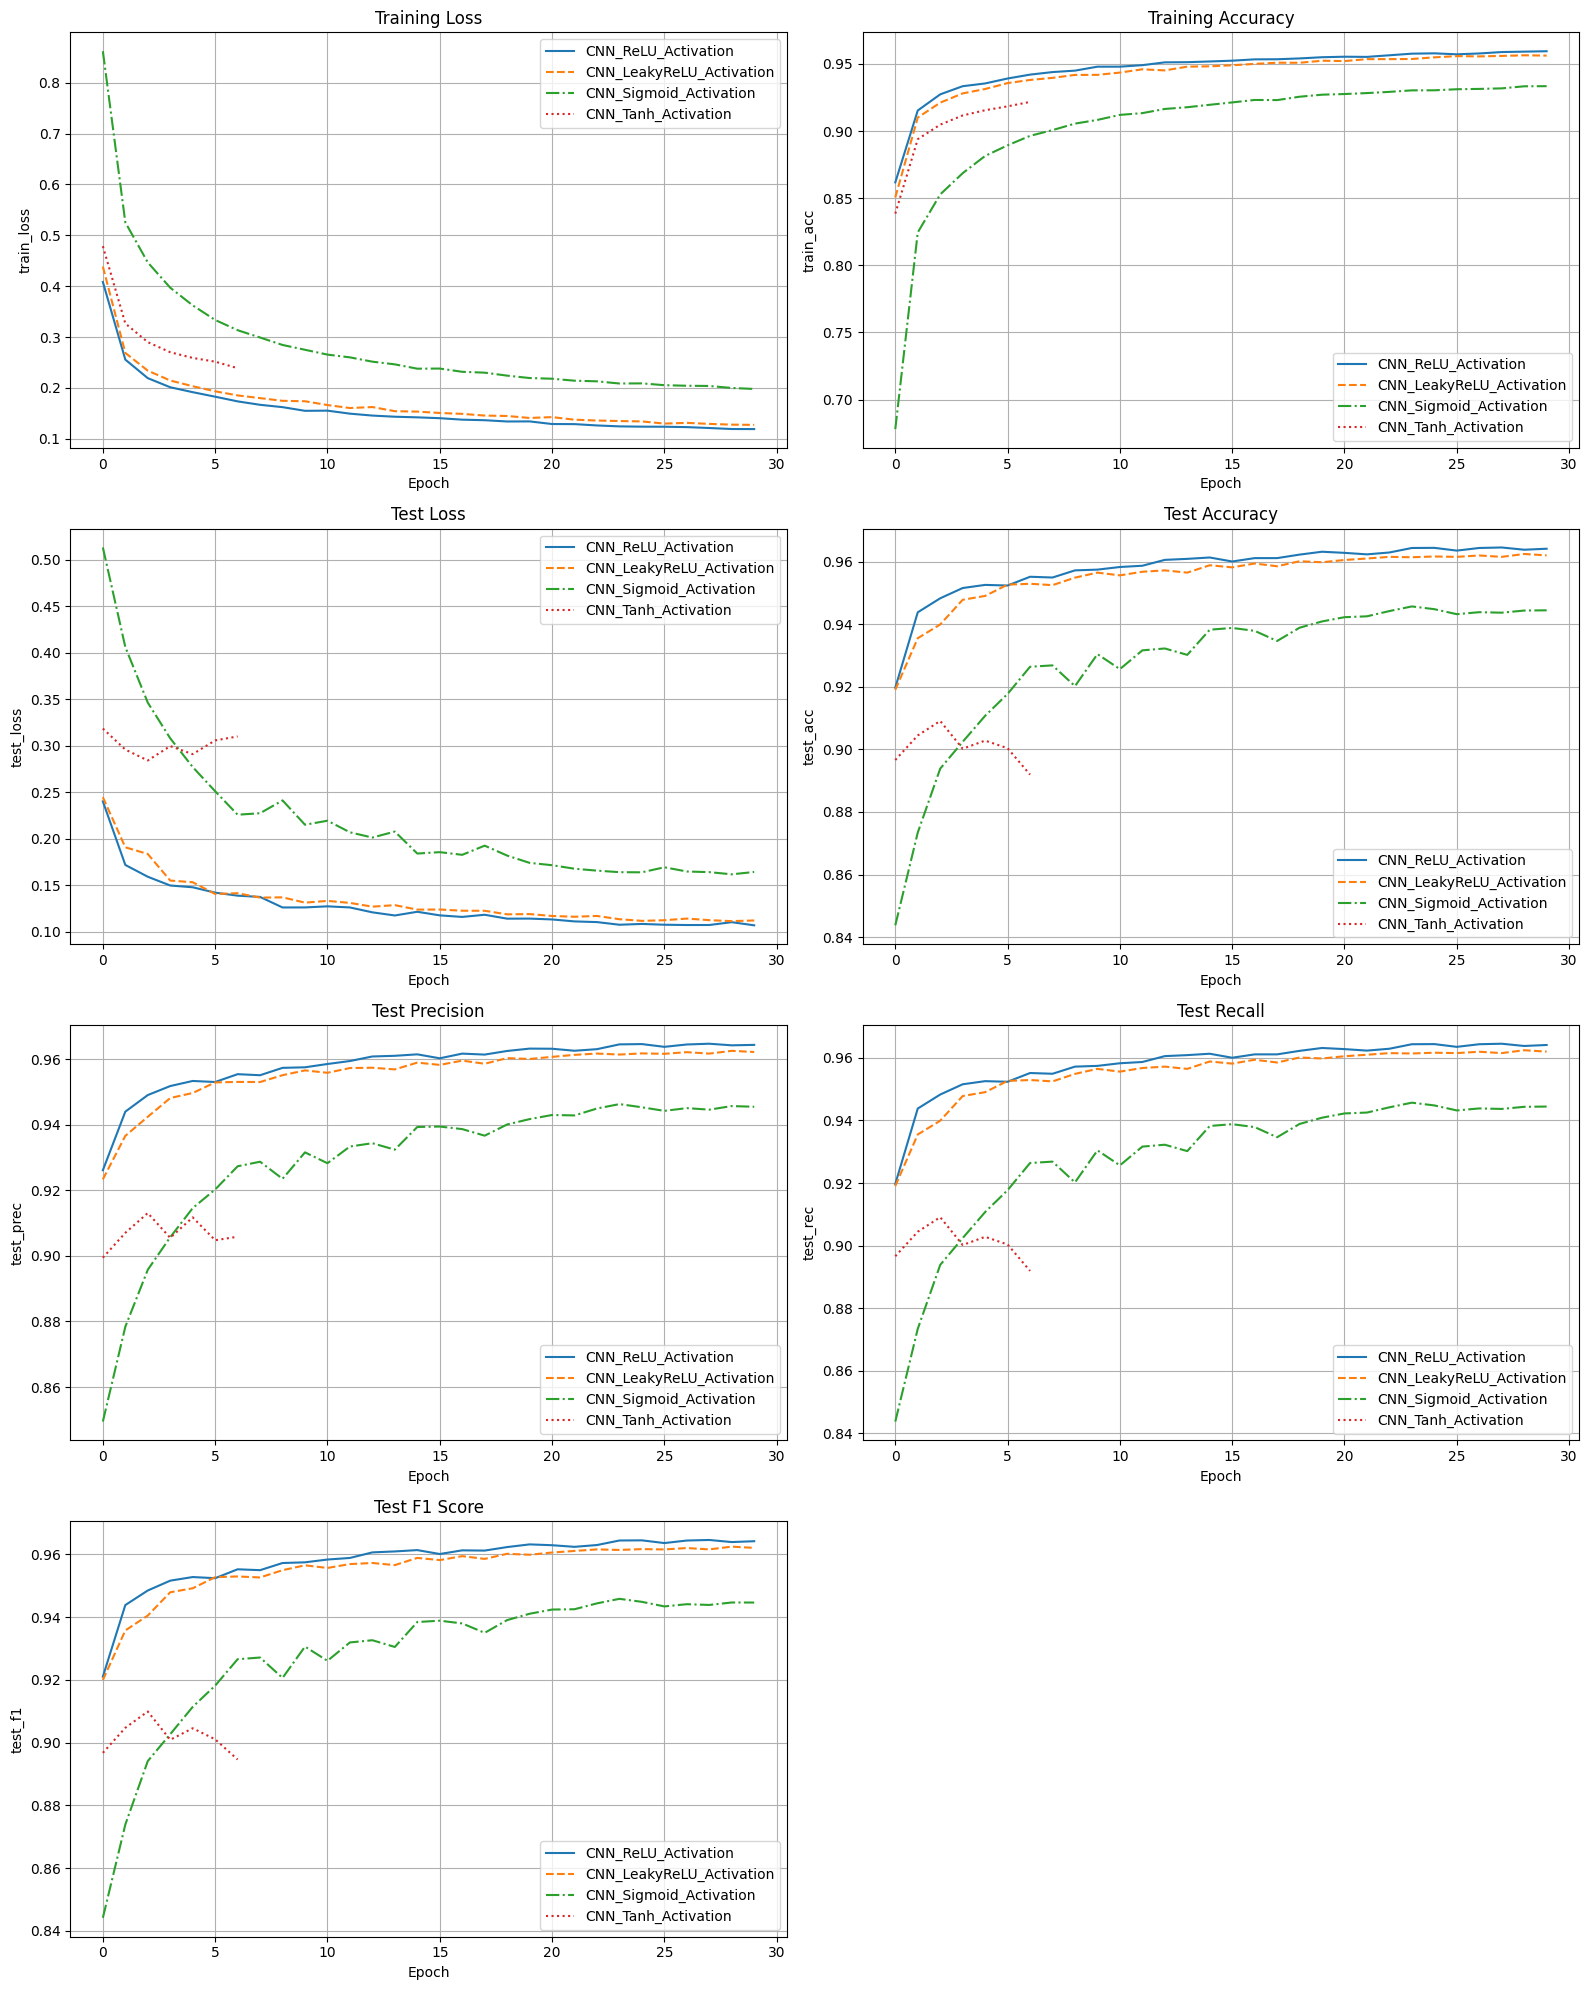

In [65]:
plot_training_history(cnn_activation_functions_result)

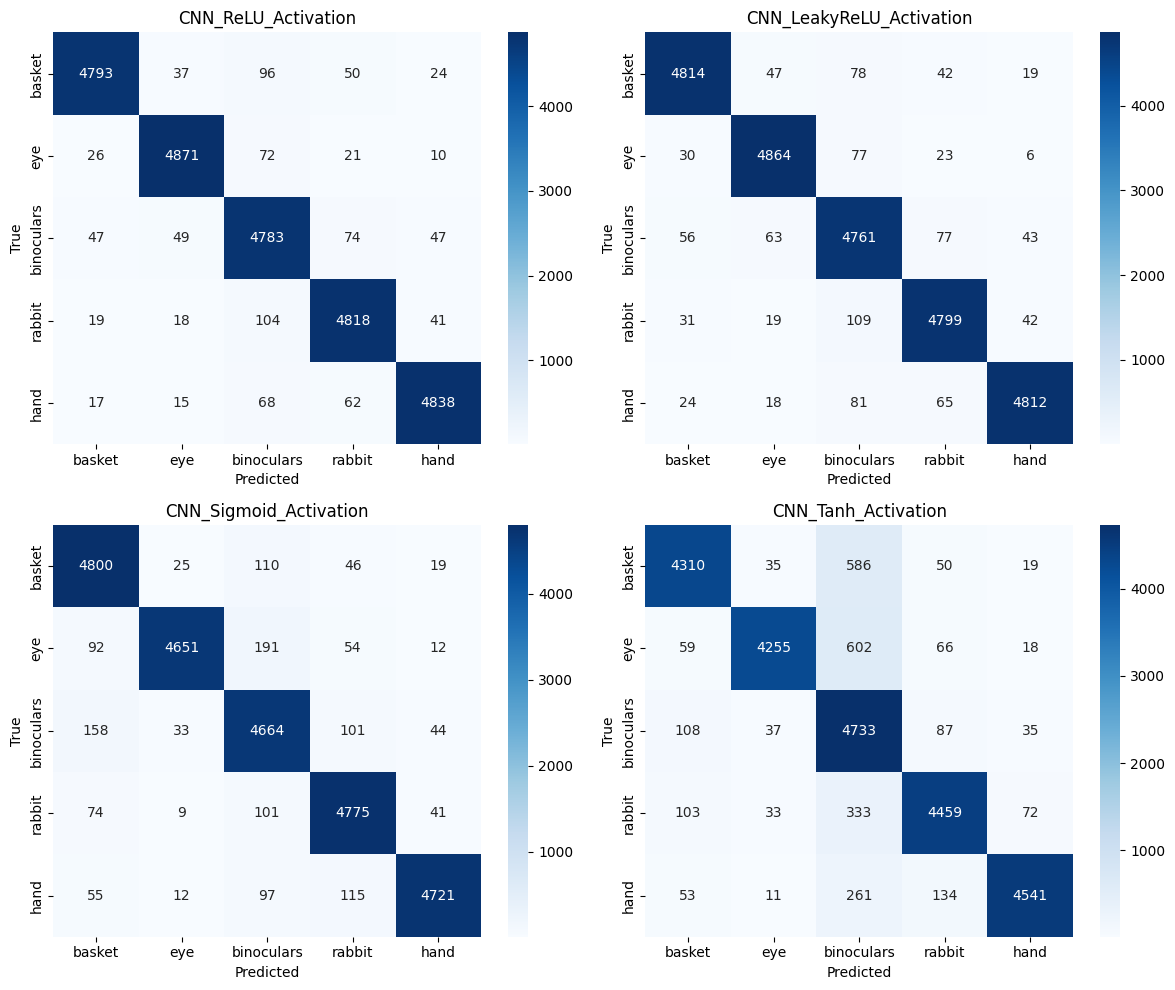

In [66]:
plot_confusion_matrices(cnn_activation_functions_result)

##### Result: 

You can see from both the metrics and the confusion matrices that using a sigmoid activation isn't a good choice. Tanh already performs significantly better. However he ReLU boost the performance by a great margin.

On the other my initial hypothesis seemed to be wrong since both ReLu and LeakyReLu perform nearly equal. Therefor I will continue with LeakyReLu.

#### Additional Improvements

The notebook referred to in the beginning mentioned additional improvements, which I want to add stepwise in order to evaluate the improvements they yield.

- Instead of using 1 covolutional layer with kernel size 5, use 2 convolutional layers with kernel size 3 to make the layer more nonlinear
- Removing the pooling layers and instead do a convolutional layer with kernel size 5 and stride 2 to reduce the image (basically a lernable pooling layer)
- Add Batch Normalization

The notebook also mentioned data augmentation, but I already incorporated that.

In [67]:
nets = 4

cnn_improvements = ['tuned_base', '2x3', '2x3_Stride2', '2x3_Stride2_Batch_Norm']

cnn_improvement_models = {f'CNN_{name}': BaseModule() for name in cnn_improvements}

for i, model in enumerate(cnn_improvement_models.values()):
    # 1 Conv5 -> Conv3 + Conv3
    if i == 0:
        model.layers.append(nn.Conv2d(1, 32, kernel_size=5, padding='same'))
        model.layers.append(nn.LeakyReLU())
    else:
        model.layers.append(nn.Conv2d(1, 23, kernel_size=3, padding='same'))
        model.layers.append(nn.LeakyReLU())

        # Batch Norm
        if i == 3:
            model.layers.append(nn.BatchNorm2d(32))

        model.layers.append(nn.Conv2d(32, 32, kernel_size=3, padding='same'))
        model.layers.append(nn.LeakyReLU())

        # Batch Norm
        if i == 3:
            model.layers.append(nn.BatchNorm2d(32))

    # MaxPool2d -> Conv3 Stride2
    if i <= 1:
        model.layers.append(nn.Dropout(0.3))
        model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    else:
        model.layers.append(nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1))
        model.layers.append(nn.LeakyReLU())

        # Batch Norm
        if i == 3:
            model.layers.append(nn.BatchNorm2d(32))

        model.layers.append(nn.Dropout(0.3))

    # 1 Conv5 -> Conv3 + Conv3
    if i == 0:
        model.layers.append(nn.Conv2d(32, 64, kernel_size=5, padding='same'))
        model.layers.append(nn.LeakyReLU())
    else:
        model.layers.append(nn.Conv2d(32, 64, kernel_size=3, padding='same'))
        model.layers.append(nn.LeakyReLU())

        # Batch Norm
        if i == 3:
            model.layers.append(nn.BatchNorm2d(64))

        model.layers.append(nn.Conv2d(64, 64, kernel_size=3, padding='same'))
        model.layers.append(nn.LeakyReLU())

        # Batch Norm
        if i == 3:
            model.layers.append(nn.BatchNorm2d(64))

    # MaxPool2d -> Conv3 Stride2
    if i <= 1:
        model.layers.append(nn.Dropout(0.3))
        model.layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    else:
        model.layers.append(nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1))
        model.layers.append(nn.LeakyReLU())

        # Batch Norm
        if i == 3:
            model.layers.append(nn.BatchNorm2d(64))

        model.layers.append(nn.Dropout(0.3))

    model.layers.append(nn.Flatten())
    model.layers.append(nn.Linear(64*7*7, 256))
    model.layers.append(nn.LeakyReLU())

    # Batch Norm
    if i == 3:
        model.layers.append(nn.BatchNorm1d(256))

    model.layers.append(nn.Dropout(0.3))
    model.layers.append(nn.Linear(256, 5))

    model.to(DEVICE)

print_model_summary(cnn_improvement_models)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
         LeakyReLU-2           [-1, 32, 28, 28]               0
           Dropout-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          51,264
         LeakyReLU-6           [-1, 64, 14, 14]               0
           Dropout-7           [-1, 64, 14, 14]               0
         MaxPool2d-8             [-1, 64, 7, 7]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                  [-1, 256]         803,072
        LeakyReLU-11                  [-1, 256]               0
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 5]           1,285
Total params: 856,453
Trainable params:

RuntimeError: Given groups=1, weight of size [32, 32, 3, 3], expected input[2, 23, 28, 28] to have 32 channels, but got 23 channels instead

In [ ]:
cnn_improvement_models_result = evaluate_models(cnn_improvement_models, save_best=True)

In [ ]:
plot_training_history(cnn_improvement_models_result)

In [ ]:
plot_confusion_matrices(cnn_improvement_models_result)

#### Result:

You can observe that all these improvements help with model performance. Splitting up each convolutional layer into two operations seems to add the greatest improvements, while the other improvements only marginally help.

However I think at about 97% accuracy in the training set with a fairly compact model I think I have assembled a quite good CNN. 

#### Hyperparameter Tuning

Last I want to see, if can squeeze out a bit more performance by using a different optimizer and learning rate scheduler combinations, increasing the patience and training for a few more epochs. Since none of the models did stop early in the last experiment I suspect that there is some more accuracy left to be attained ;-)

Combinations to be tested:

**Adam with ConsineAnnealingLR**
    I want to try if smoothing out the learning rate decay over the number of epochs provide better convergence that a fixed decay.

**Adam with CosineAnnealingWarmRestarts**
    I suspect that in the later stage of training because of the low learning rate the models maybe isn't able to escape local minimas an therefor can't make any big improvements. I want to validate this by using a ConsineAnnealing scheduler with works with oscillations that help in the later training stage.

**Adam with ReduceLROnPlateau**
    Instead of generally reducing the learning rate in every epoch it might be smarter to just reduce it, if some metrics stops improving. I want to check this by using the 
    ReduceLROnPlateau Scheduler.

**SGD with Momentum and StepLR** 
    Even though Adam has been performing great so far SGD with it's more jumpy nature helps to escape local minimas better and avoids stagnation.

**RMSProp with ConsineAnnealingLR**
    Since I use data augmentation the test loss during training is a bit noisy. RMSProp may be able to smooth the loss out and provide better results.

**Adam with ExponentialLR**
    This is the setup I've used before, this serves as a reference

In [ ]:
NUM_EPOCHS = 40
PATIENCE = 7
results = {name: None for name in ['CNN_adam_cosine_annealing', 'CNN_adam_cosine_annealing_warm_restart', 'CNN_adam_reduce_lr_on_plateau', 'CNN_SGD_momentum', 'CNN_RMSProp_cosine_annealing', 'CNN_adam_exponential']}

# Copy the best model from last experiment
cnn_optimizer_models = [copy.deepcopy(cnn_improvement_models['CNN_2x3_Stride2_Batch_Norm']) for _ in range(len(results))]

# Reset weights
def reset_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):  # Reset Conv2d layers
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He Initialization
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # Set biases to 0
        elif isinstance(m, nn.Linear):  # Reset Linear layers
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')  # He Initialization for ReLU
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # Set biases to 0
        elif isinstance(m, nn.BatchNorm2d):  # Reset BatchNorm layers
            nn.init.ones_(m.weight)  # Set gamma (scale) to 1
            nn.init.zeros_(m.bias)   # Set beta (shift) to 0

for m in cnn_optimizer_models:
    reset_weights(m)

In [ ]:
# Adam with CosineAnnealingLR
optimizer = optim.Adam(cnn_optimizer_models[0].parameters(), lr=LEARNING_RATE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.0001)

history = run_training_for_model(
    cnn_optimizer_models[0],
    TRAIN_LOADER,
    TEST_LOADER,
    CRITERION,
    optimizer,
    scheduler,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    model_name='optimizer/CNN_adam_cosine_annealing',
    save_best=True
)

results['CNN_adam_cosine_annealing'] = history

In [ ]:
# Adam with CosineAnnealingWarmRestarts
optimizer = optim.Adam(cnn_optimizer_models[1].parameters(), lr=LEARNING_RATE)

# First restart 20 epochs when to model was slowly
scheduler = CosineAnnealingWarmRestarts(optimizer, 20, 2, eta_min=0.0001)

history = run_training_for_model(
    cnn_optimizer_models[1],
    TRAIN_LOADER,
    TEST_LOADER,
    CRITERION,
    optimizer,
    scheduler,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    model_name='optimizer/CNN_adam_cosine_annealing_warm_restart',
    save_best=True
)

results['CNN_adam_cosine_annealing_warm_restart'] = history

In [ ]:
# Adam with ReduceLROnPlateau
reset_weights(cnn_optimizer_models[2])  # Reset weights again for a fair comparison
optimizer = optim.Adam(cnn_optimizer_models[2].parameters(), lr=LEARNING_RATE)

# Reduce the learning rate by 50% if the test accuracy isn't improving in 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

history = run_training_for_model(
    cnn_optimizer_models[2],
    TRAIN_LOADER,
    TEST_LOADER,
    CRITERION,
    optimizer,
    scheduler,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    model_name='optimizer/CNN_adam_reduce_lr_on_plateau',
    save_best=True
)

results['CNN_adam_reduce_lr_on_plateau'] = history

In [ ]:
# SGD

# Higher learning rate to speed up convergence, momentum for additional acceleration
optimizer = optim.SGD(cnn_optimizer_models[3].parameters(), lr=0.01, momentum=0.9)

# Reduce LR every 10 epochs by a factor of 0.1
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

history = run_training_for_model(
    cnn_optimizer_models[3],
    TRAIN_LOADER,
    TEST_LOADER,
    CRITERION,
    optimizer,
    scheduler,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    model_name='optimizer/CNN_SGD_momentum',
    save_best=True
)

results['CNN_SGD_momentum'] = history

In [ ]:
# RMSProp with ConsineAnnealingLR

reset_weights(cnn_optimizer_models[4])  # Reset weights again for a fair comparison

# alpha = weight of past gradients
optimizer = optim.RMSprop(cnn_optimizer_models[4].parameters(), lr=0.001, alpha=0.9)
scheduler = CosineAnnealingLR(optimizer, T_max=40, eta_min=0.0001)

history = run_training_for_model(
    cnn_optimizer_models[4],
    TRAIN_LOADER,
    TEST_LOADER,
    CRITERION,
    optimizer,
    scheduler,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    model_name='optimizer/CNN_RMSProp_cosine_annealing',
    save_best=True
)

results['CNN_RMSProp_cosine_annealing'] = history

In [ ]:
# Last but not least the exponential scheduler I used before with more epochs

reset_weights(cnn_optimizer_models[5])  # Reset weights again for a fair comparison
optimizer = optim.Adam(cnn_optimizer_models[5].parameters(), lr=LEARNING_RATE)
scheduler = LambdaLR(optimizer, lr_lambda)

history = run_training_for_model(
    cnn_optimizer_models[5],
    TRAIN_LOADER,
    TEST_LOADER,
    CRITERION,
    optimizer,
    scheduler,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    model_name='optimizer/CNN_adam_exponential',
    save_best=True
)

results['CNN_adam_exponential'] = history

In [ ]:
plot_training_history(results)

In [ ]:
plot_confusion_matrices(results)

#### Result:

Apparently the Exponential Learning Rate Scheduler already performed very well. However we were able to push the test accuracy to 97% by using only reducing the learning rate when training plateaus.

## Transfer Learning

Next I want to try adapting already pretrained models and compare them to the CNN I constructed.
I decided to take a small, a medium sized and a rather large model to test if a larger model size will result in better accuracy. 

Namely I choose:
- MobileNet V3 Small (small model)
- EfficientNet B0 (medium model)
- VisionTransformer16 (big model)

In [ ]:
pretrained_models = {
    'MobileNet': models.mobilenet_v3_small(weights='DEFAULT'),
    'EfficientNet': models.efficientnet_b0(weights='DEFAULT'),
    'ViT': models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
}

# Adapt the final fully connected layer
pretrained_models['MobileNet'].classifier[3] = nn.Linear(pretrained_models['MobileNet'].classifier[3].in_features, 5)
pretrained_models['EfficientNet'].classifier[1] = nn.Linear(pretrained_models['EfficientNet'].classifier[1].in_features, 5)
pretrained_models['ViT'].heads.head = nn.Linear(pretrained_models['ViT'].heads.head.in_features, 5)

# Freeze all layers except the last two (weight + bias)
for idx, model in enumerate(pretrained_models.values()):
    for param in list(model.parameters())[:(-2 + (-6 + (2 *idx)))]:
        param.requires_grad = False

    model.to(DEVICE)

# Make sure only the last layers need parameters
for (name, model) in pretrained_models.items():
    print(f'{name} Trainable Layers:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
    print('')

# Create transforms
transfer_transforms = v2.Compose([
    v2.Resize(256),
    v2.Grayscale(3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

vit_transforms = v2.Compose([
    v2.Resize(224),
    v2.Grayscale(3),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transfer_train_transforms = v2.Compose([
    # Include data augmentation, but exclude normalization
    *train_transforms.transforms[:-3],
    *transfer_transforms.transforms
])

vit_train_transforms = v2.Compose([
    # Include data augmentation, but exclude normalization
    *train_transforms.transforms[:-3],
    *vit_transforms.transforms
])

def get_transforms_for_model(model_name):
    if model_name == 'ViT':
        return vit_train_transforms, vit_transforms
    else:
        return transfer_train_transforms, transfer_transforms

In [ ]:
transfer_results = {model_name: None for model_name in pretrained_models.keys()}

# more patience
PATIENCE = 7

for idx, (name, model) in enumerate(pretrained_models.items()):
    train_transform, test_transform = get_transforms_for_model(name)
    
    transfer_train_data = QuickDrawDataset('../dataset/train.csv', '../dataset/images', train_transform)
    transfer_test_data = QuickDrawDataset('../dataset/test.csv', '../dataset/images', test_transform)

    transfer_train_loader = DataLoader(transfer_train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=6, pin_memory=True)
    transfer_test_loader = DataLoader(transfer_test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)
    
    # Only optimize the last two layers
    transfer_optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

    # Only save weights for ViT because otherwise the pt file get too large
    save_weights_only = True if name == 'ViT' else False

    result = run_training_for_model(
        model,
        transfer_train_loader,
        transfer_test_loader,
        CRITERION,
        transfer_optimizer,
        ReduceLROnPlateau(transfer_optimizer, mode='max', patience=3, factor=0.5),
        DEVICE,
        40,
        f'/transfer/{name}',
        save_best=True,
        save_weights_only=save_weights_only
    )

    transfer_results[name] = result

In [ ]:
final_results = {'My-CNN': results['CNN_adam_reduce_lr_on_plateau'], **transfer_results}

plot_training_history(final_results)

In [ ]:
plot_confusion_matrices(final_results)

#### Result

After running training a few times an unfreezeing a bit more layers in each run I found that this setup worked quite well. Not only training the new classifier but rather a few more layers based on the model size yielded better accuracy. 

Also suprisingly the smallest model performed best at 96.8% and therefore is almost equal to my created CNN however the model i created is smaller and more accurate therefore I will use this model as my final classification model.

## Usage example
Last here is a simple example on how to use the model to classify the images

In [ ]:
# Load model
model = torch.load('../weights/classifier/optimizer/CNN_adam_reduce_lr_on_plateau.pt', weights_only=False).to(DEVICE)
model.eval()

# Sample five images of each class
with torch.no_grad():
    images = sample_image_from_each_class(n=5) 

    preds = []
    samples = []

    for true_label, img_path in images:
        image = Image.open(f'../dataset/images/{img_path}').convert('L')

        # Apply normalization
        image_tensor = test_transforms(image).unsqueeze(0).to(DEVICE)

        # CNN outputs logits -> argmax needed to get predictions
        logits = model(image_tensor)
        pred_label = torch.argmax(logits, dim=1).item()

        preds.append(pred_label)
        samples.append(image_tensor.cpu())

    num_classes = len(classes)
    n_images_per_class = 5

    fig, axes = plt.subplots(n_images_per_class, num_classes, figsize=(num_classes * 2, n_images_per_class * 2))

    for idx, (true_label, _) in enumerate(images):
        row = idx % n_images_per_class
        col = idx // n_images_per_class

        ax = axes[row, col]
        ax.imshow(samples[idx].squeeze(), cmap='gray')
        ax.axis('off')

        # Predicted class name
        pred_name = classes[preds[idx]]
        color = 'green' if preds[idx] == true_label else 'red'

        # Set predicted label as the title with color
        ax.set_title(pred_name, color=color, fontsize=9)

        # Show class name as x-axis label on top row only
        if row == 0:
            ax.set_xlabel(classes[col], fontsize=10)

    plt.suptitle('Sampled Images with Predictions', y=1.02)
    plt.tight_layout()
    plt.show()